In [1]:
# Jupyterでmatplotlibを使用する宣言と、使用するライブラリの定義
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 動画の描画関数の宣言
# 参考URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
 
 
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
 
    def animate(i):
        patch.set_data(frames[i])
 
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)
 
    anim.save('movie_cartpole_DQN.mp4')  # 動画のファイル名と保存です
    display(display_animation(anim, default_mode='loop'))

In [3]:
# namedtupleを生成
from collections import namedtuple
 
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
# 定数の設定
 
ENV = 'CartPole-v0'  # 使用する課題名
GAMMA = 0.99  # 時間割引率
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES = 500  # 最大試行回数

In [5]:
# 経験を保存するメモリクラスを定義します
 
 
class ReplayMemory:
 
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # メモリの最大長さ
        self.memory = []  # 経験を保存する変数
        self.index = 0  # 保存するindexを示す変数
 
    def push(self, state, action, state_next, reward):
        """state, action, state_next, rewardをメモリに保存します"""
 
        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す
 
        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存します
        self.memory[self.index] = Transition(state, action, state_next, reward)
 
        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす
 
    def sample(self, batch_size):
        """batch_size分だけ、ランダムに保存内容を取り出します"""
        return random.sample(self.memory, batch_size)
 
    def __len__(self):
        return len(self.memory)

In [6]:
# エージェントが持つ脳となるクラスです、DQNを実行します
# Q関数をディープラーニングのネットワークをクラスとして定義
 
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
 
BATCH_SIZE = 32
CAPACITY = 10000
 
 
class Brain:
    def __init__(self, num_states, num_actions):
        self.num_states = num_states  # CartPoleは状態数4を取得
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得
 
        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)
 
        # ニューラルネットワークを構築
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(self.num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, self.num_actions))
 
        print(self.model)  # ネットワークの形を出力
 
        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
 
    def replay(self):
        """Experience Replayでネットワークの重みを学習 """
 
        # メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return
 
        # メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)
 
        # ミニバッチの作成-----------------
 
        # transitionsは1stepごとの(state, action, state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)×BATCH_SIZE
        # これをミニバッチにしたい。つまり
        # (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))
 
        # cartpoleがdoneになっておらず、next_stateがあるかをチェックするマスクを作成
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)))
 
        # バッチから状態、行動、報酬を格納（non_finalはdoneになっていないstate）
        # catはConcatenates（結合）のことです。
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるのですが、
        # それを size BATCH_SIZEx4 に変換します
        state_batch = Variable(torch.cat(batch.state))
        action_batch = Variable(torch.cat(batch.action))
        reward_batch = Variable(torch.cat(batch.reward))
        non_final_next_states = Variable(torch.cat([s for s in batch.next_state
                                                    if s is not None]))
 
        # ミニバッチの作成終了------------------
 
        # ネットワークを推論モードに切り替える
        self.model.eval()
 
        # Q(s_t, a_t)を求める
        # self.model(state_batch)は、[torch.FloatTensor of size BATCH_SIZEx2]になっており、
        # 実行したアクションに対応する[torch.FloatTensor of size BATCH_SIZEx1]にするために
        # gatherを使用します。
        state_action_values = self.model(state_batch).gather(1, action_batch)
 
        # max{Q(s_t+1, a)}値を求める。
        # 次の状態がない場合は0にしておく
        next_state_values = Variable(torch.zeros(
            BATCH_SIZE).type(torch.FloatTensor))
 
        # 次の状態がある場合の値を求める
        # 出力であるdataにアクセスし、max(1)で列方向の最大値の[値、index]を求めます
        # そしてその値（index=0）を出力します
        next_state_values[non_final_mask] = self.model(
            non_final_next_states).data.max(1)[0]
 
        # 教師となるQ(s_t, a_t)値を求める
        expected_state_action_values = reward_batch + GAMMA * next_state_values
 
        # ネットワークを訓練モードに切り替える
        self.model.train()
 
        # 損失関数を計算する。smooth_l1_lossはHuberlossです
    
        #print(state_action_values)
        #print(expected_state_action_values.view(32, 1))
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.view(32, 1))
 
        # ネットワークを更新します
        self.optimizer.zero_grad()  # 勾配をリセット
        loss.backward()  # バックプロパゲーションを計算
        self.optimizer.step()  # 結合パラメータを更新
 
    def decide_action(self, state, episode):
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))
 
        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()  # ネットワークを推論モードに切り替える
            action = self.model(Variable(state)).data.max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出します = max(1)[1]
            # .view(1,1)はtorch.LongTensor of size 1　を size 1x1 に変換します
 
        else:
            # 0,1の行動をランダムに返す
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 0,1の行動をランダムに返す
            # actionは[torch.LongTensor of size 1x1]の形になります
 
        return action

In [7]:
# CartPoleで動くエージェントクラスです、棒付き台車そのものになります
 
 
class Agent:
    def __init__(self, num_states, num_actions):
        """課題の状態と行動の数を設定します"""
        self.num_states = num_states  # CartPoleは状態数4を取得
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成
        #print('a')
 
    def update_q_function(self):
        """Q関数を更新します"""
        self.brain.replay()
 
    def get_action(self, state, step):
        """行動の決定します"""
        action = self.brain.decide_action(state, step)
        return action
 
    def memorize(self, state, action, state_next, reward):
        """memoryオブジェクトに、state, action, state_next, rewardの内容を保存します"""
        self.brain.memory.push(state, action, state_next, reward)

In [8]:
# CartPoleを実行する環境のクラスです
 
 
class Environment:
 
    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        self.num_states = self.env.observation_space.shape[0]  # 課題の状態と行動の数を設定
        self.num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        # 環境内で行動するAgentを生成
        self.agent = Agent(self.num_states, self.num_actions)
        self.total_step = np.zeros(10)  # 10試行分の立ち続けたstep数を格納し、平均ステップ数を出力させます
 
    def run(self):
        """メインの実行"""
 
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        episode_final = False  # 最後の試行フラグ
        frames = []  # 最後の試行を動画にするために画像を格納する変数
        #print('b')
 
        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化
            state = observation  # 観測をそのまま状態sとして使用
            state = torch.from_numpy(state).type(
                torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
 
            # 今、FloatTensorof size 4になっているので、size 1x4に変換
            state = torch.unsqueeze(state, 0)
            #print(state)
            #print(episode)
            #print('c')
            for step in range(MAX_STEPS):  # 1エピソードのループ
                if episode_final is True:
                    """framesに各時刻の画像を追加していく"""
                    frames.append(self.env.render(mode='rgb_array'))
 
                action = self.agent.get_action(state, episode)  # 行動を求める
                action_1 = action.numpy()
                #print(action_1[0, 0])
            
            
                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionは、torch.LongTensor of size 1x1になっているので、[0,0]を指定して、中身を取り出す
                observation_next, _, done, _ = self.env.step(action_1[0, 0])
                
                #print(observation_next)
                #print(done)
                
                #print(self.env.action_space)  #Discrete(2) = 取りうるべき行動の数が0,1であることを表す
                #print(self.env.step(action[0, 0]))
                
                
                #print('f')
                # episodeの終了評価と、state_nextを設定
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納
                    self.total_step = np.hstack(
                        (self.total_step[1:], step + 1))  # step数を保存
                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # 途中でこけたら罰則として報酬-1を与える
                        self.complete_episodes = 0  # 連続成功記録をリセット
                    else:
                        reward = torch.FloatTensor([1.0])  # 立ったまま終了時は報酬1を与える
                        self.complete_episodes = self.complete_episodes + 1  # 連続記録を更新
                else:
                    reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpyとPyTorchのテンソルに
 
                    # テンソルがsize 4になっているので、size 1x4に変換
                    state_next = torch.unsqueeze(state_next, 0)
 
                # メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)
 
                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()
 
                # 観測の更新
                state = state_next
                #print('d')
                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps：10Average = %.1lf' % (
                        episode, step + 1, self.total_step.mean()))
                    break
 
            if episode_final is True:
                # 動画を保存と描画
                display_frames_as_gif(frames)
                break
 
            # 10連続で200step立ち続けたら成功
            if self.complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True  # 次の試行を描画を行う最終試行とする

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 18 steps：10Average = 1.8
1 Episode: Finished after 13 steps：10Average = 3.1
2 Episode: Finished after 10 steps：10Average = 4.1
3 Episode: Finished after 10 steps：10Average = 5.1
4 Episode: Finished after 11 steps：10Average = 6.2
5 Episode: Finished after 13 steps：10Average = 7.5
6 Episode: Finished after 9 steps：10Average = 8.4
7 Episode: Finished after 8 steps：10Average = 9.2
8 Episode: Finished after 10 steps：10Average = 10.2
9 Episode: Finished after 11 steps：10Average = 11.3
10 Episode: Finished after 10 steps：10Average = 10.5
11 Episode: Finished after 9 steps：10Average = 10.1
12 Episode: Finished after 8 steps：10Average = 9.9
13 Episode: Finished after 10 steps：10Average = 9.9
14 Episode: Finished after 10 steps：10Average = 9.8
15

150 Episode: Finished after 200 steps：10Average = 172.4
151 Episode: Finished after 200 steps：10Average = 172.4
152 Episode: Finished after 200 steps：10Average = 172.4
153 Episode: Finished after 114 steps：10Average = 163.8
154 Episode: Finished after 200 steps：10Average = 172.9
155 Episode: Finished after 200 steps：10Average = 186.0
156 Episode: Finished after 200 steps：10Average = 191.4
157 Episode: Finished after 200 steps：10Average = 191.4
158 Episode: Finished after 200 steps：10Average = 191.4
159 Episode: Finished after 200 steps：10Average = 191.4
160 Episode: Finished after 200 steps：10Average = 191.4
161 Episode: Finished after 200 steps：10Average = 191.4
162 Episode: Finished after 200 steps：10Average = 191.4
163 Episode: Finished after 200 steps：10Average = 200.0
10回連続成功
164 Episode: Finished after 165 steps：10Average = 196.5



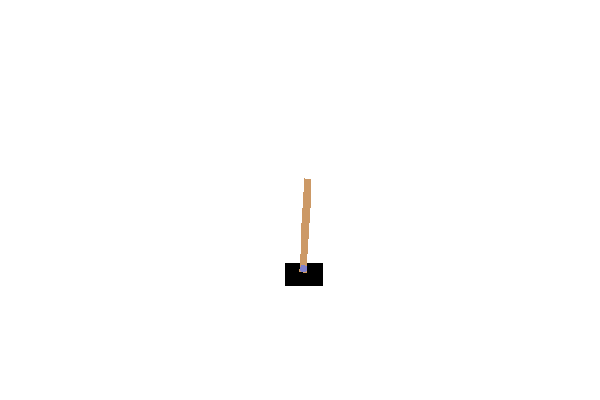
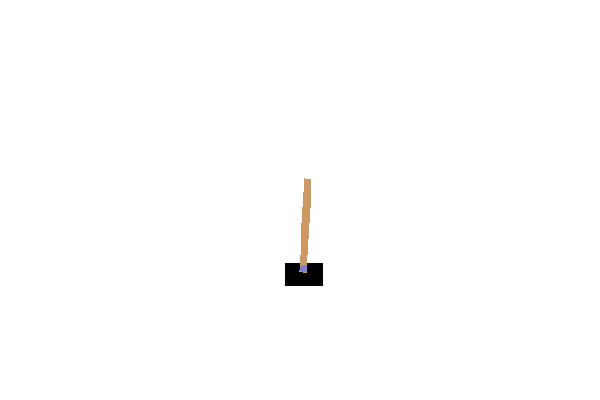
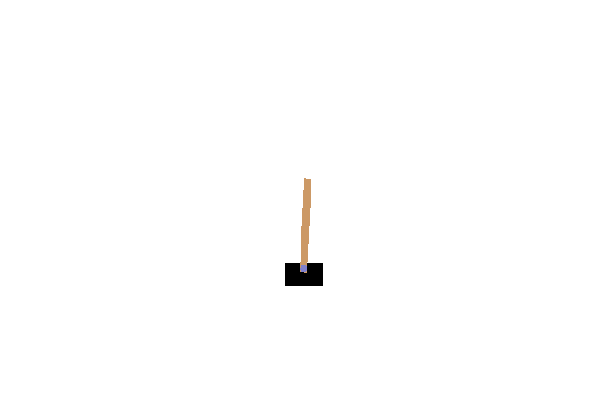
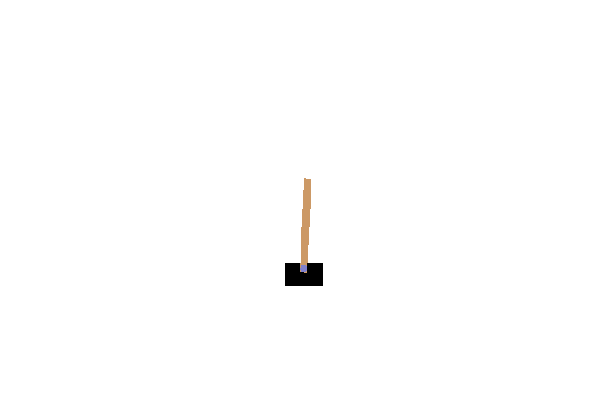
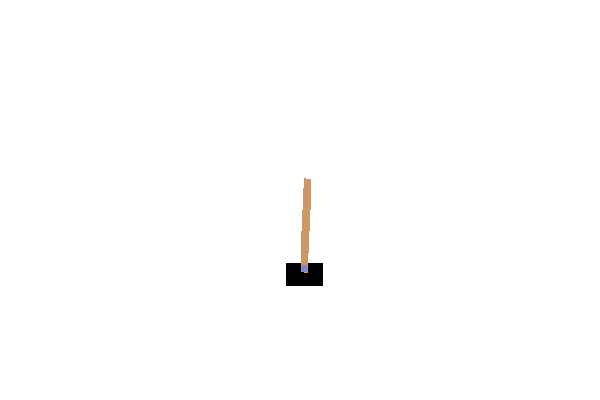
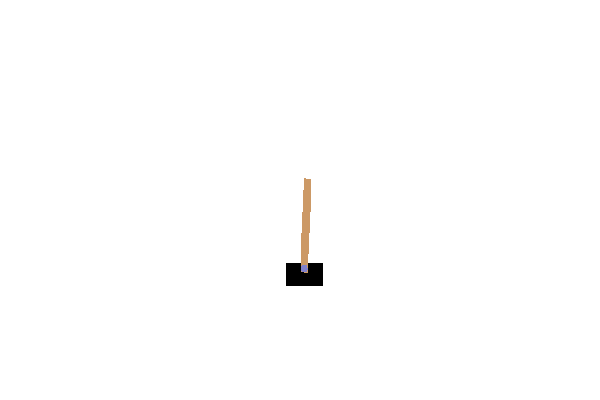
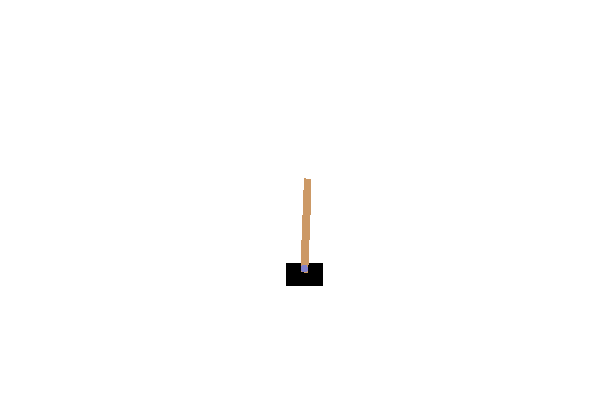
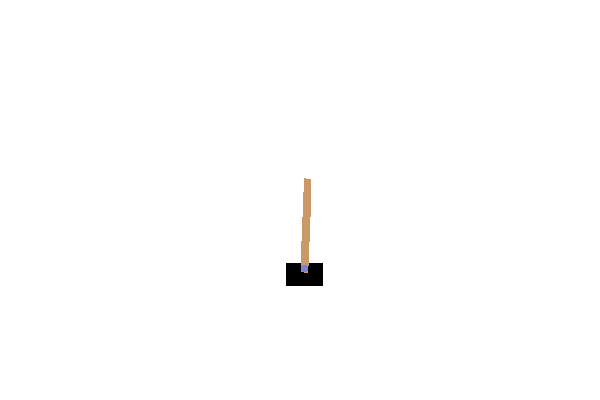
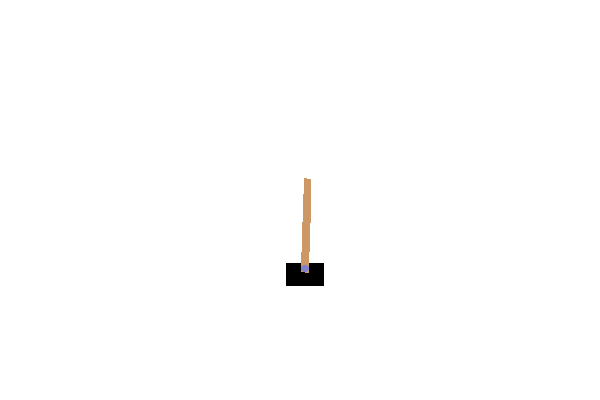
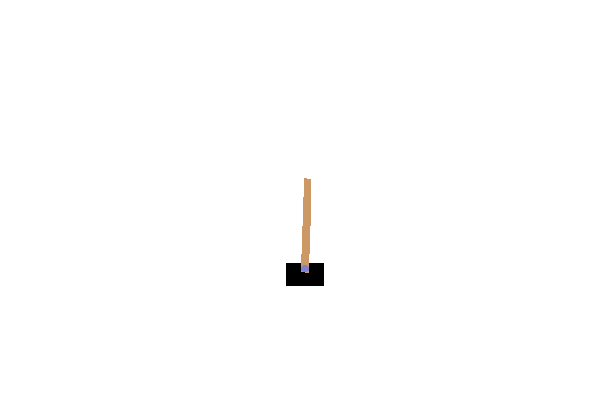
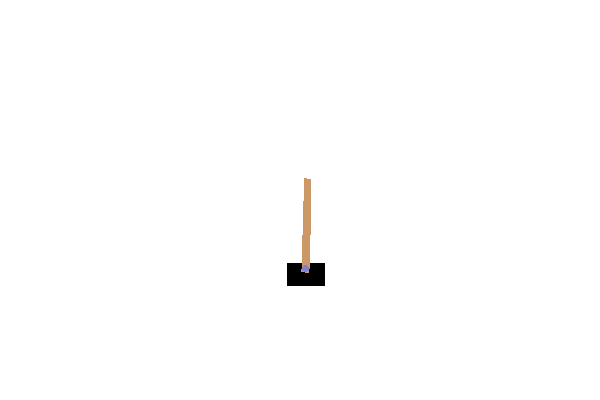
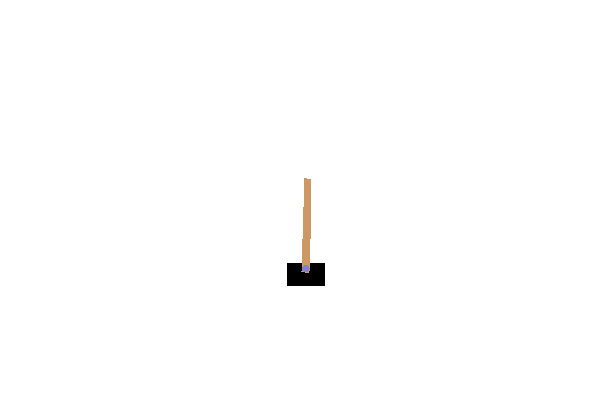
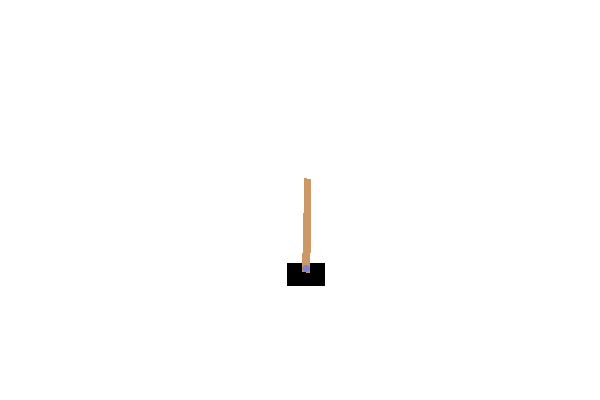
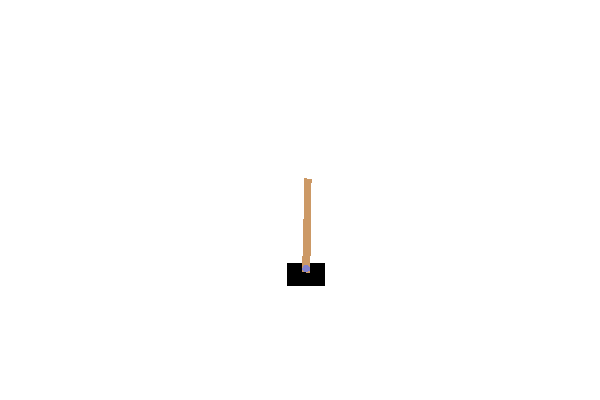
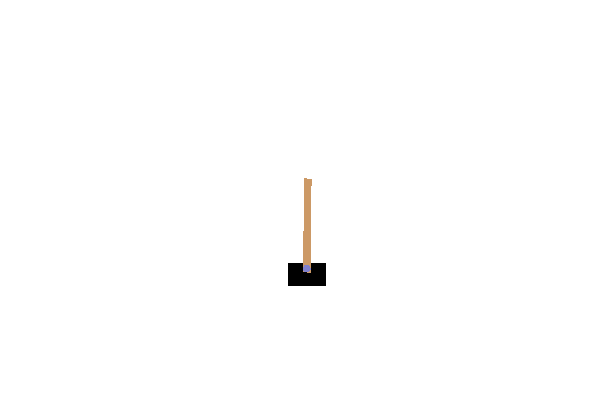
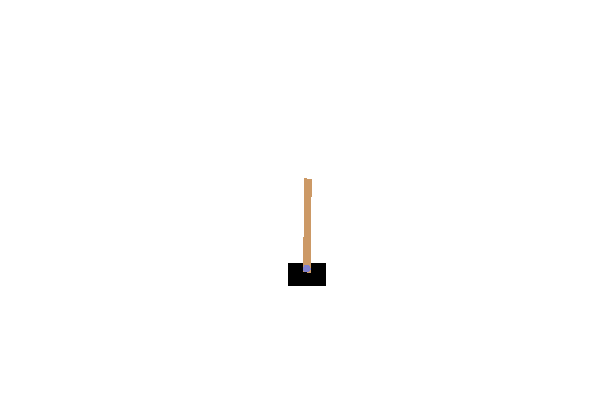
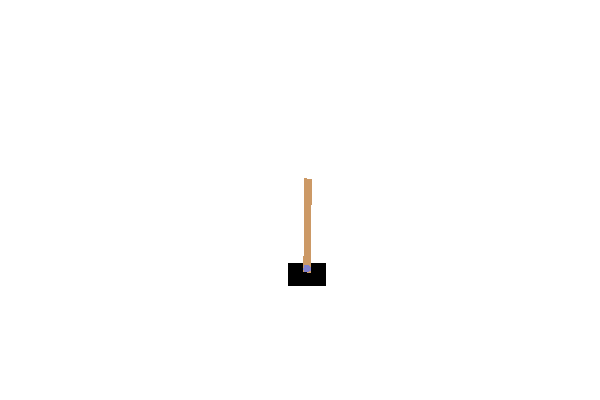
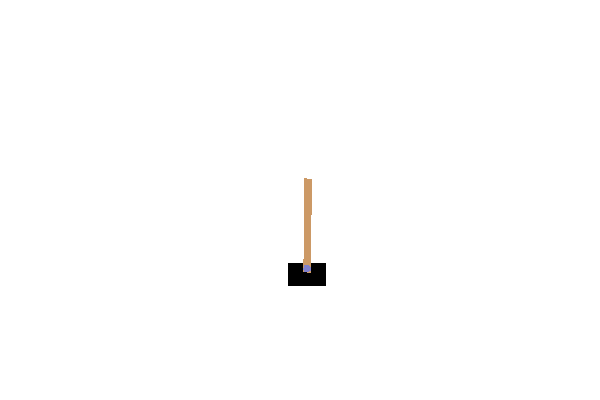
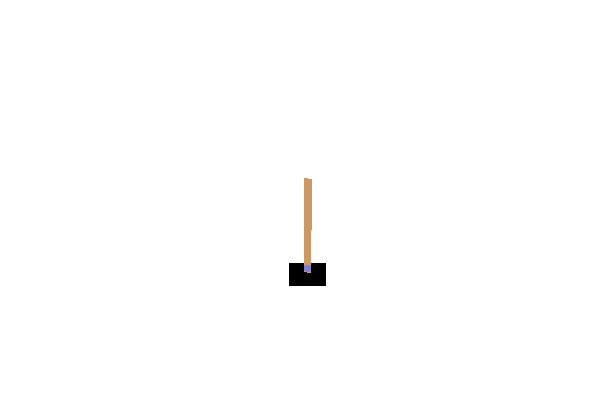
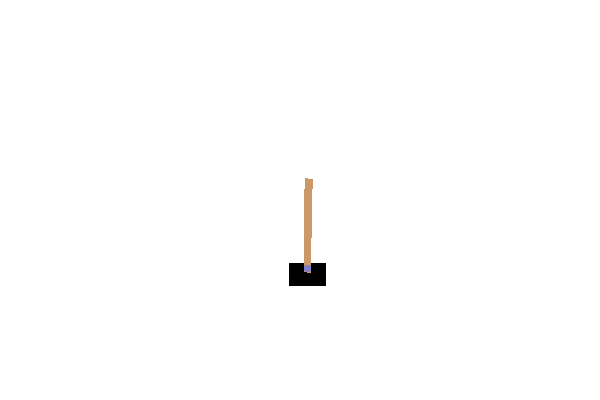
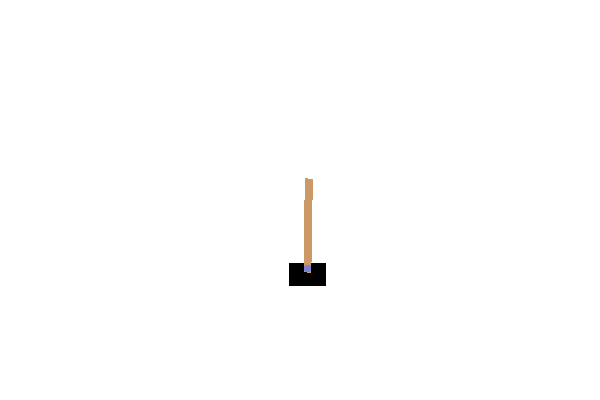
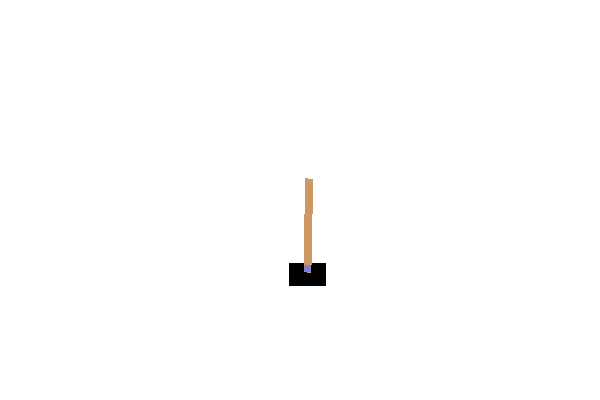
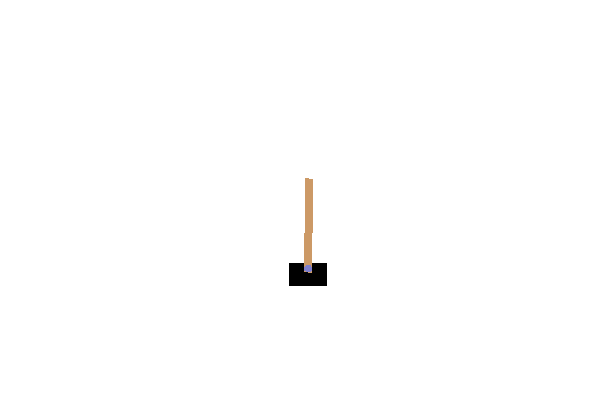
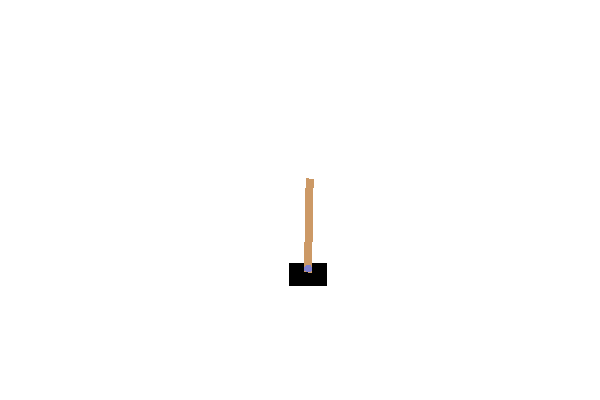
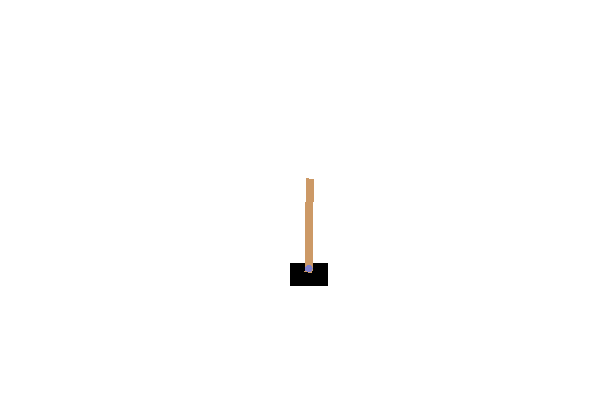
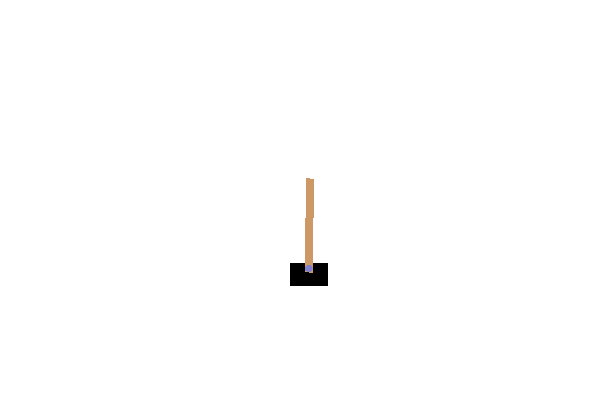
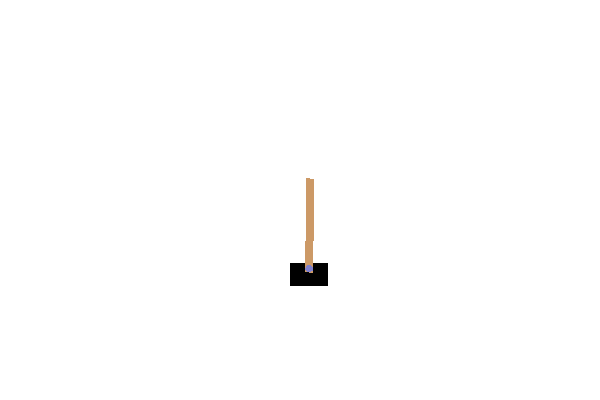
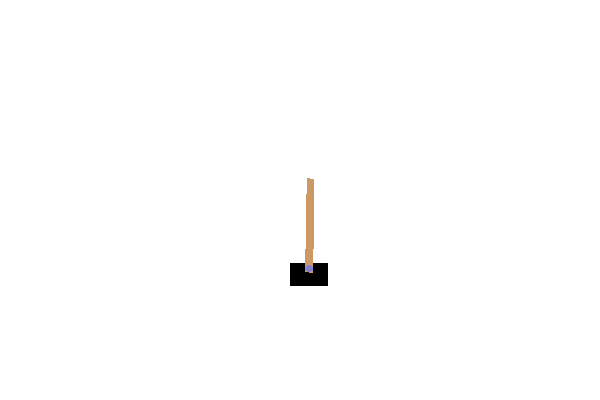
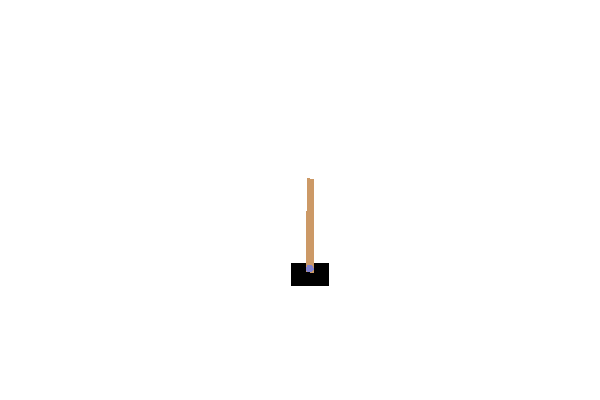
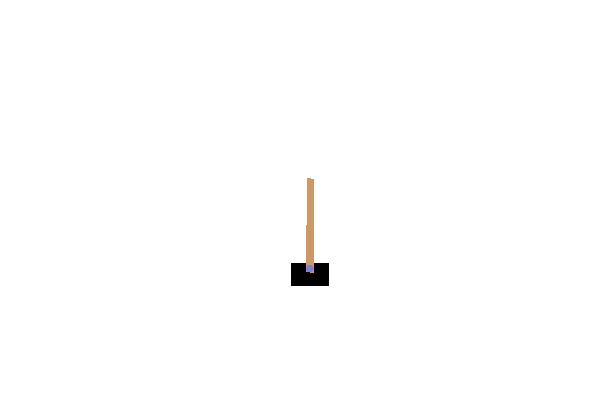
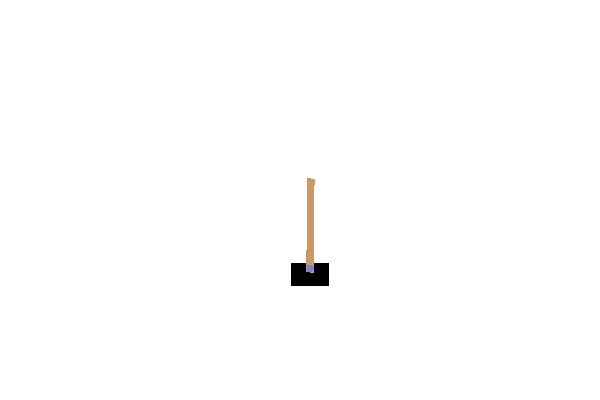
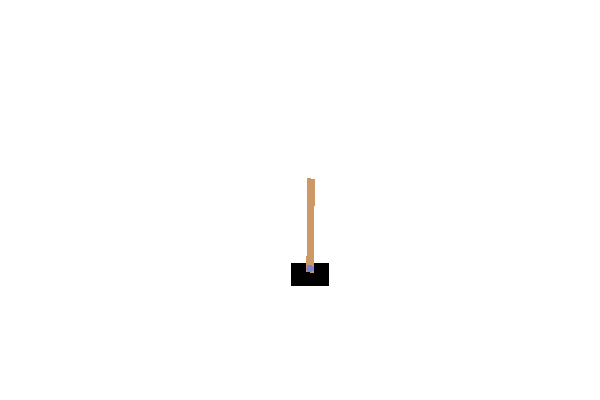
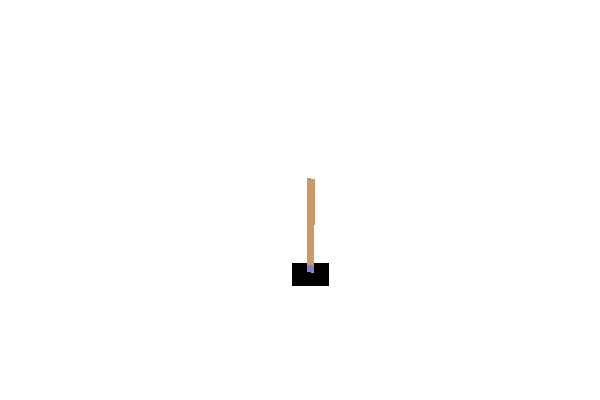
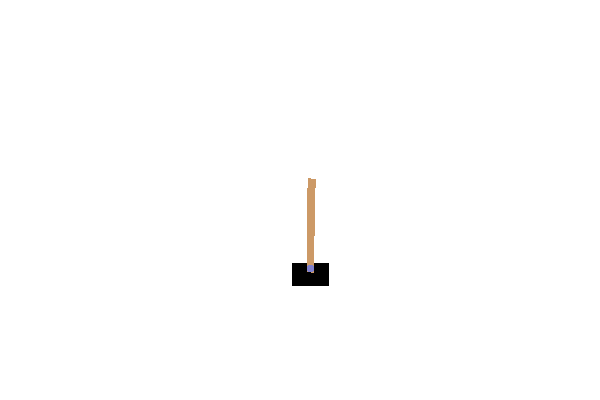
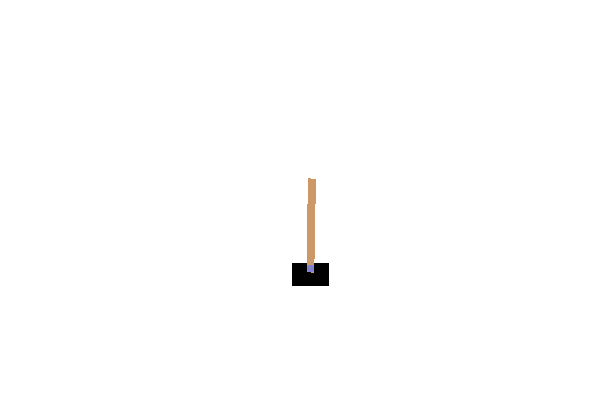
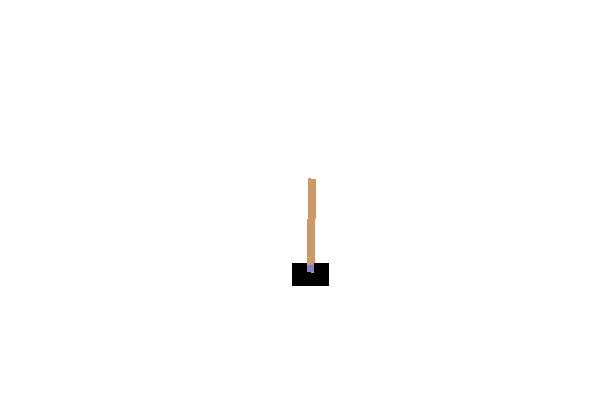
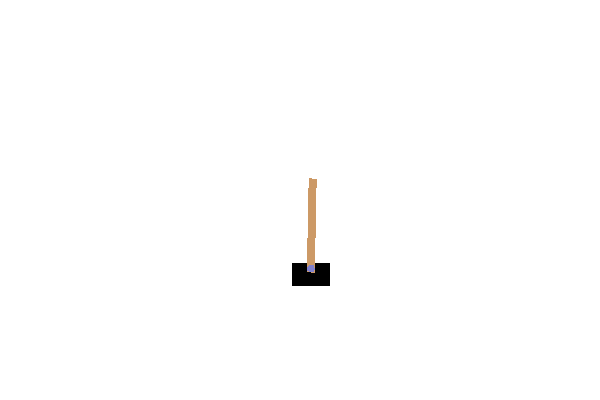
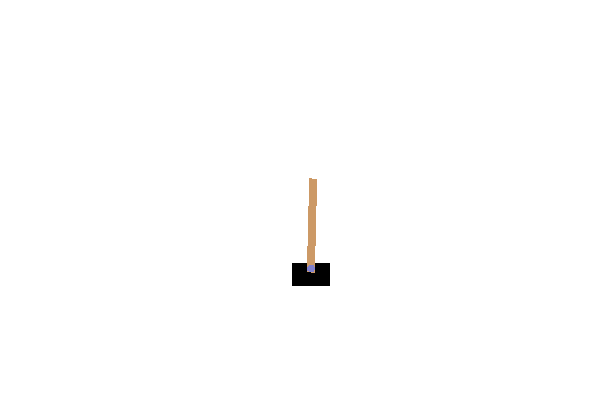
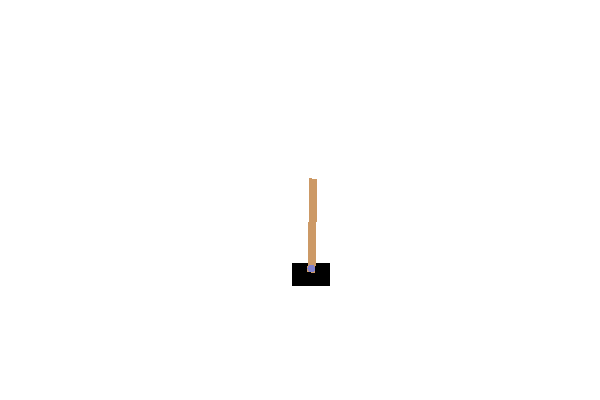
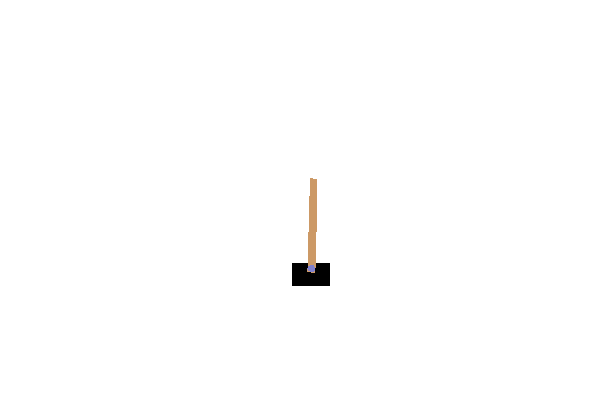
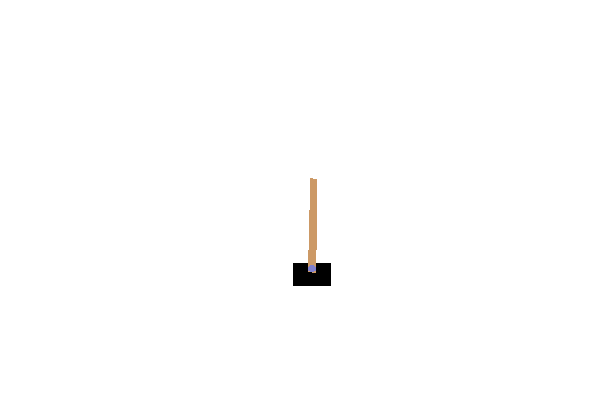
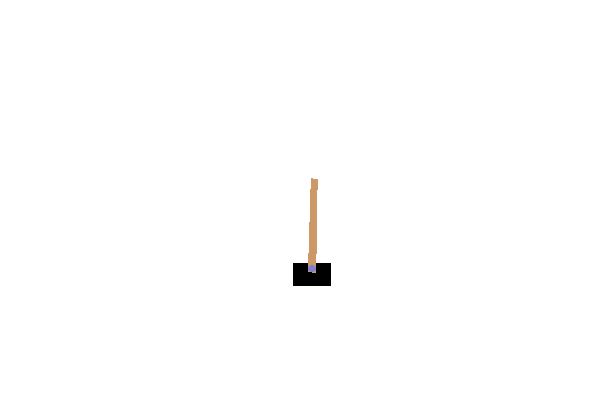
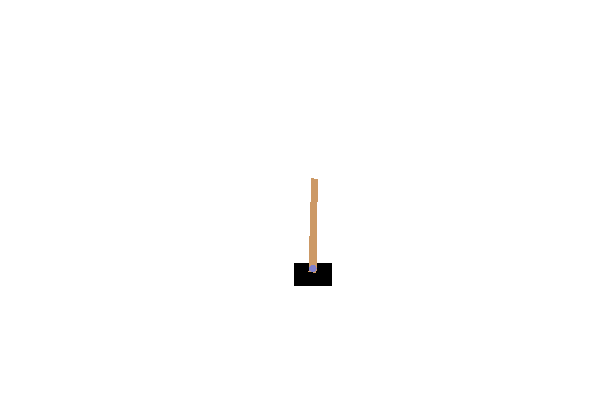
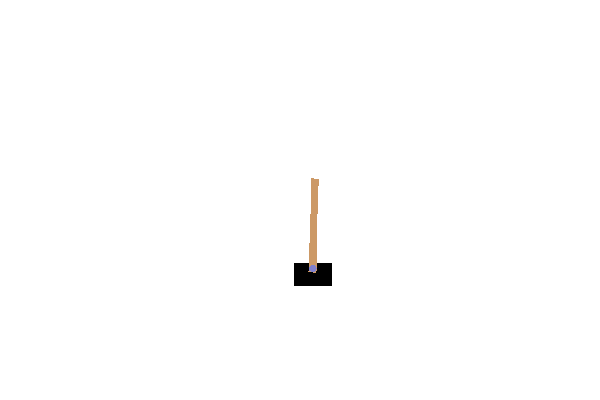
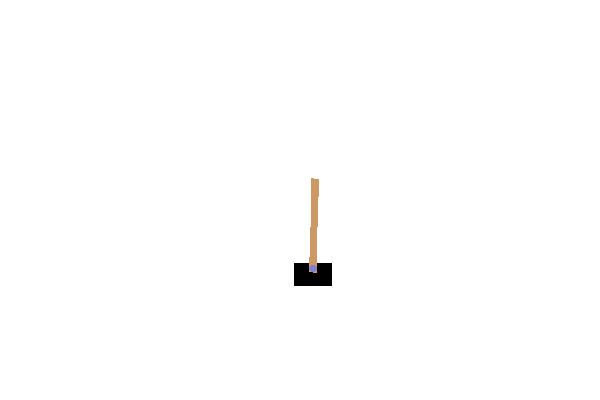
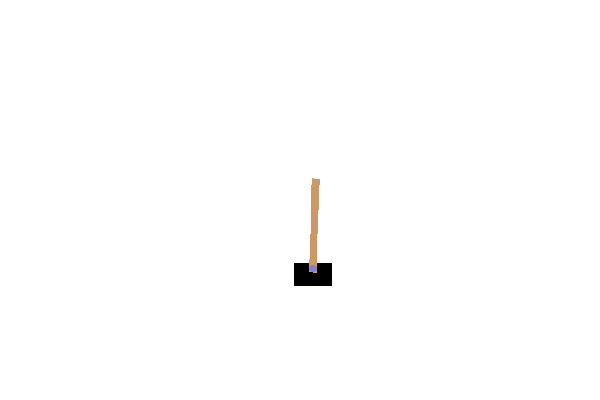
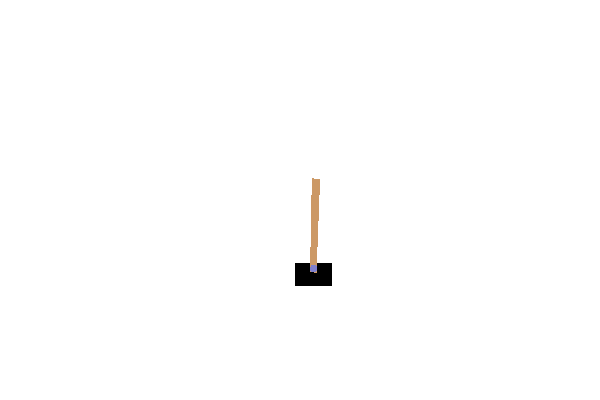
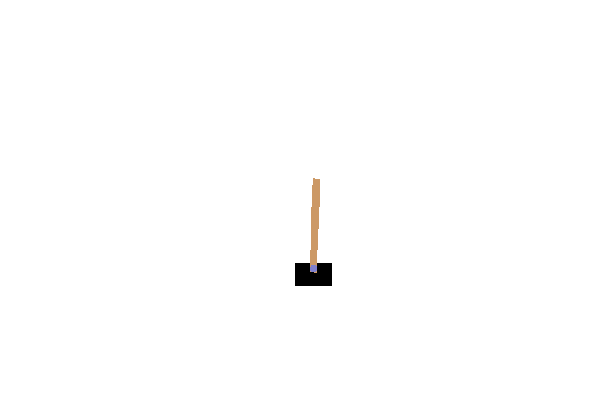
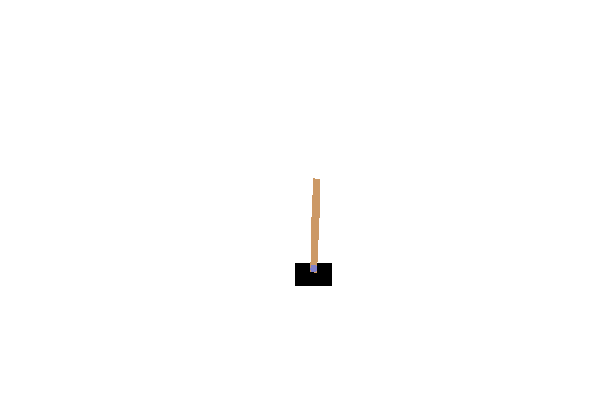
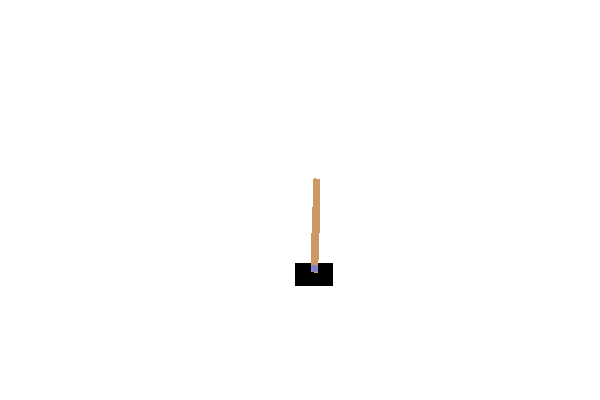
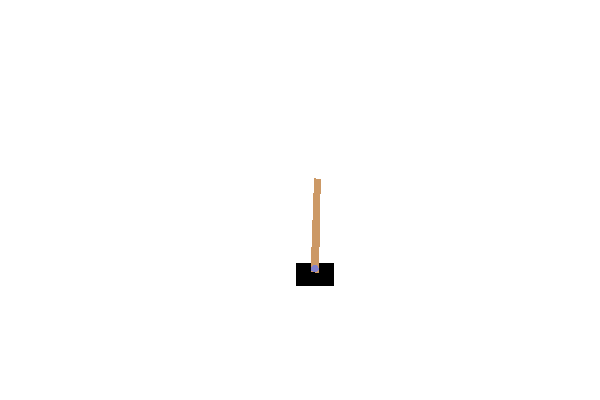
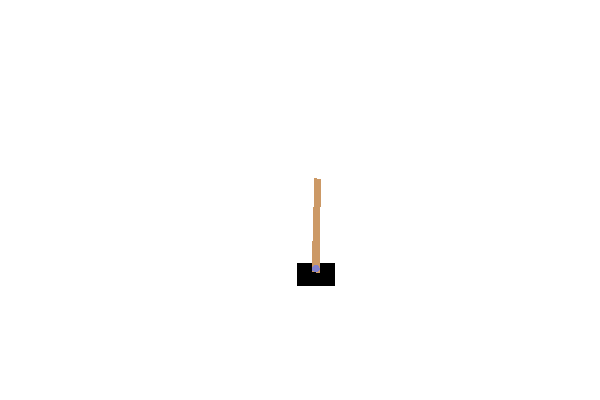
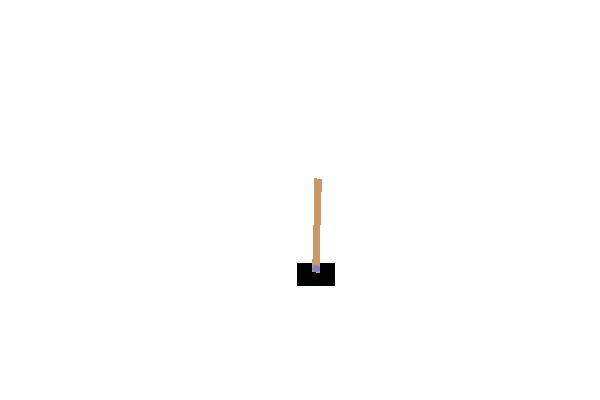
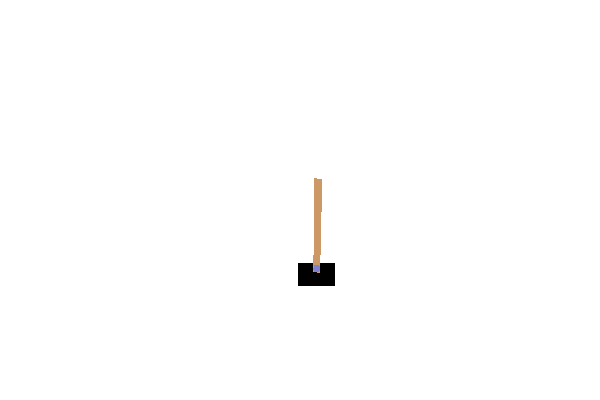
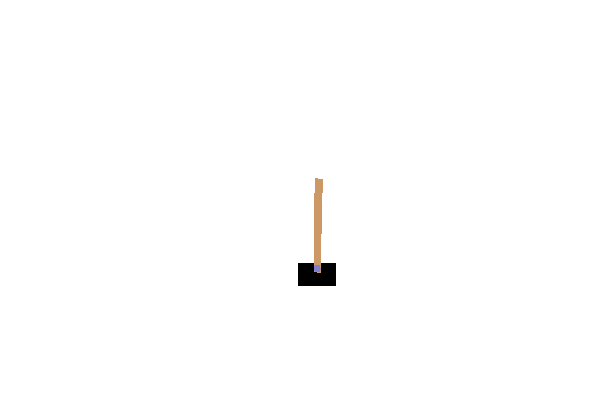
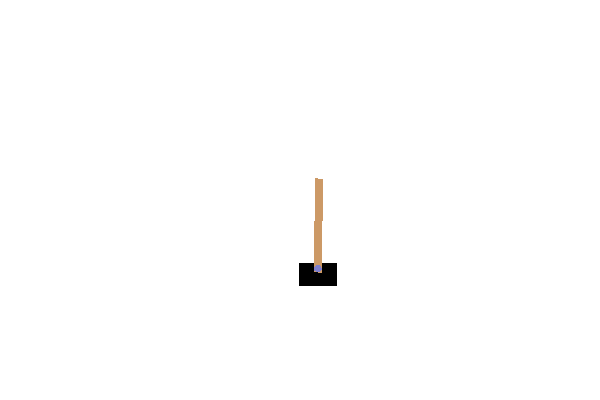
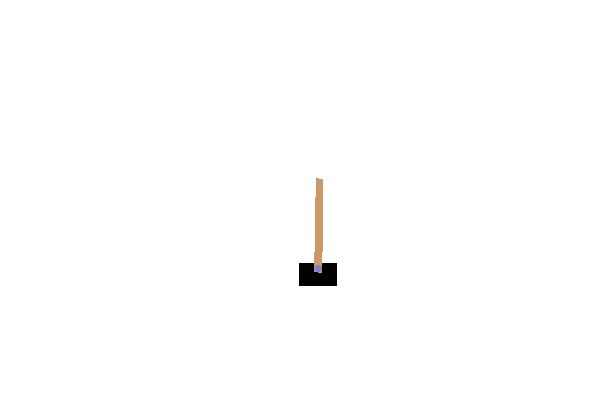
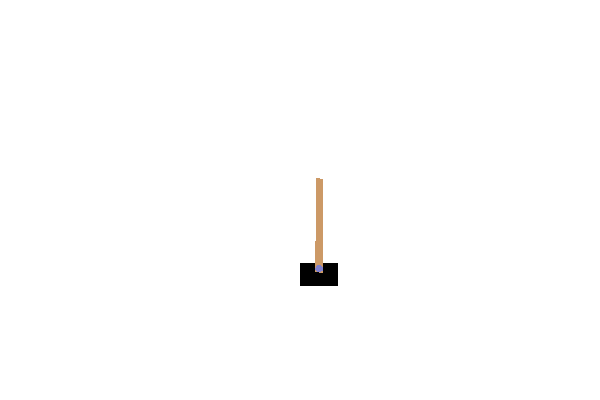
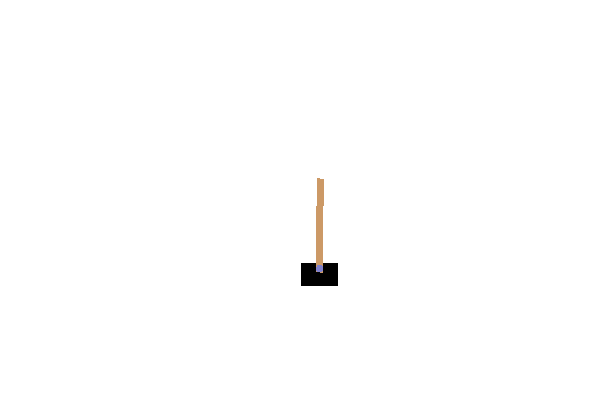
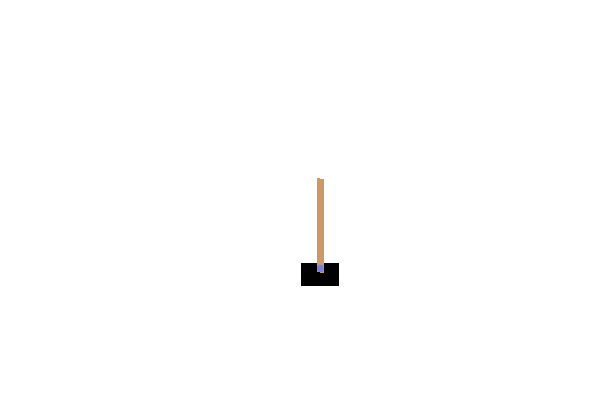
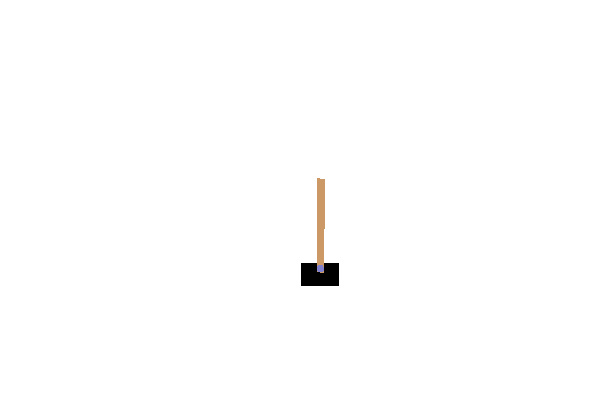
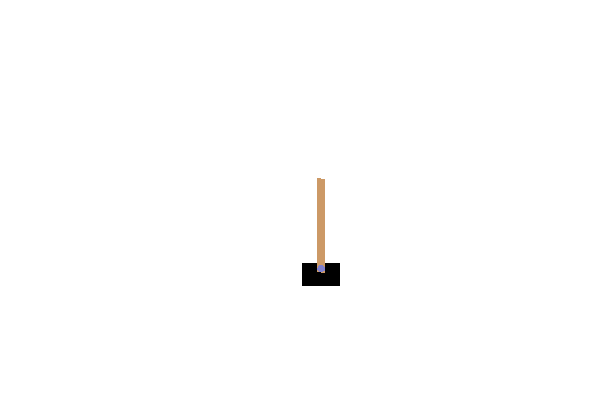
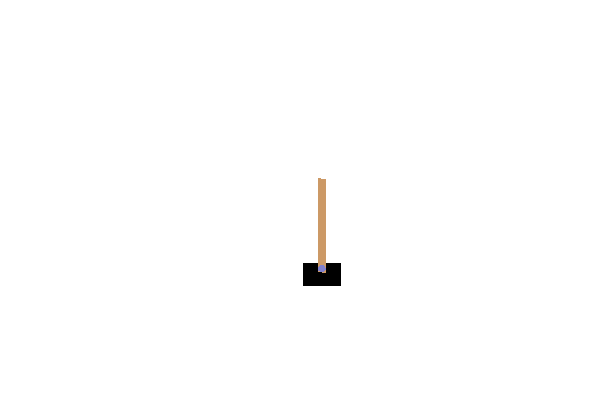
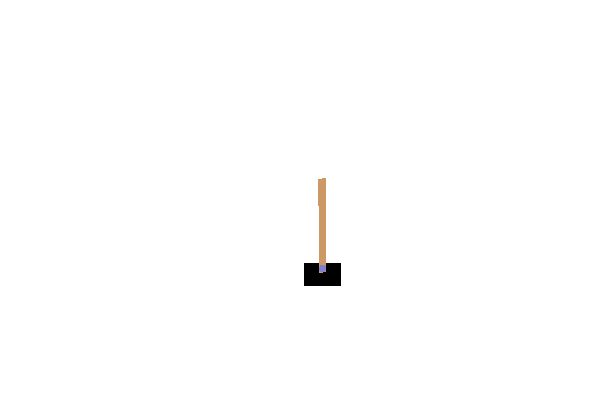
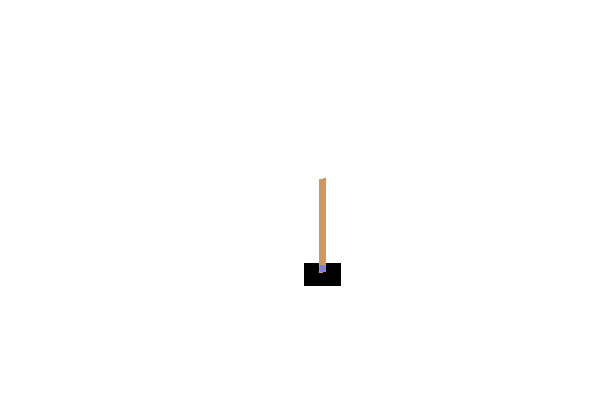
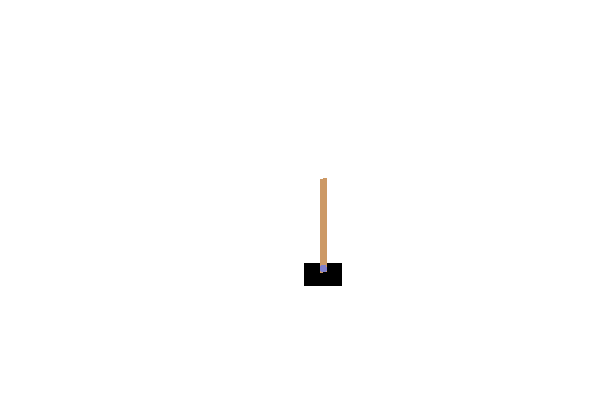
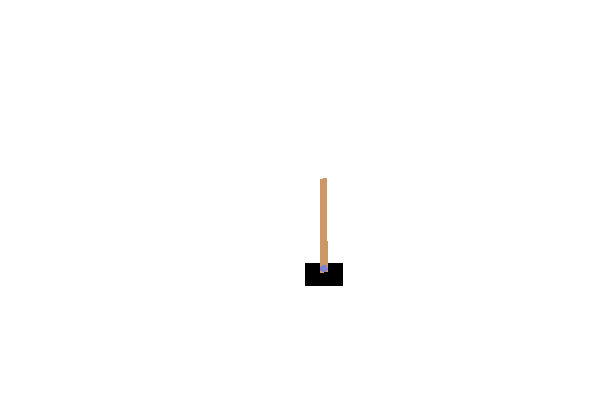
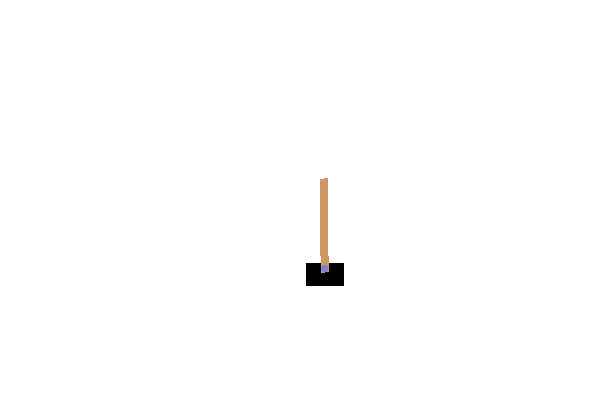
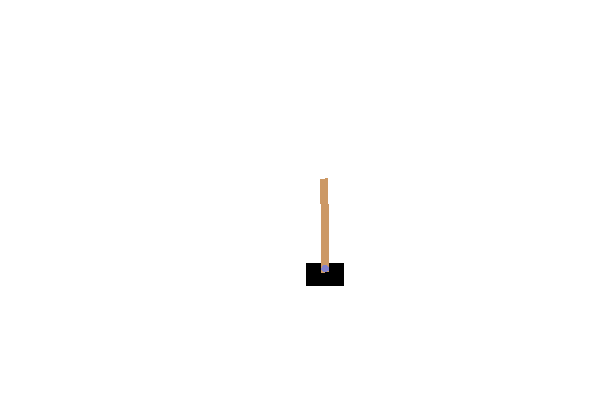
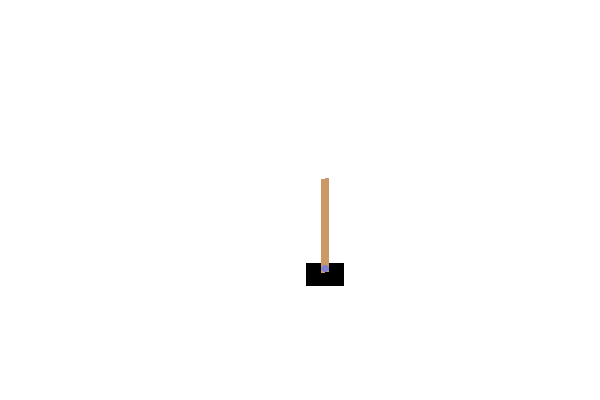
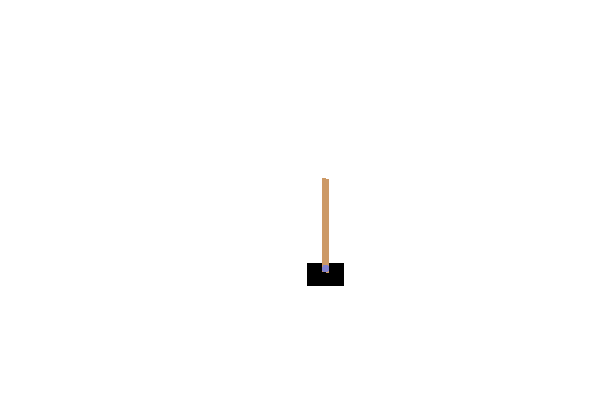
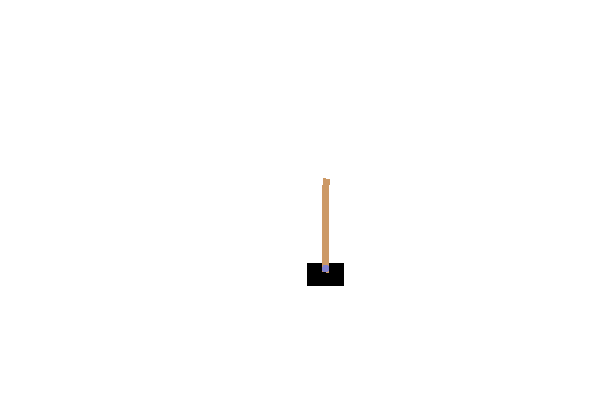
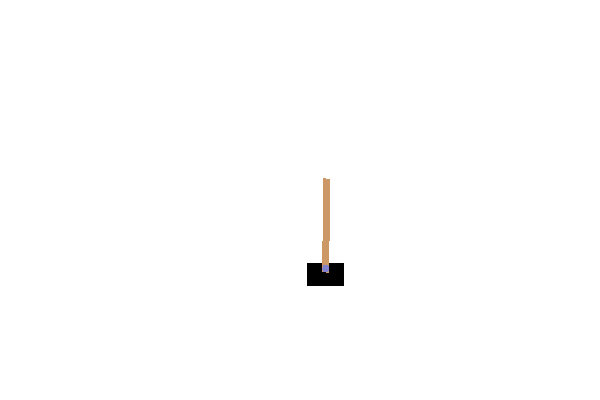
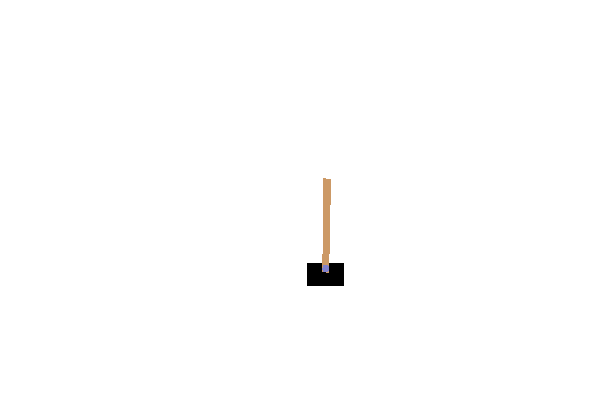
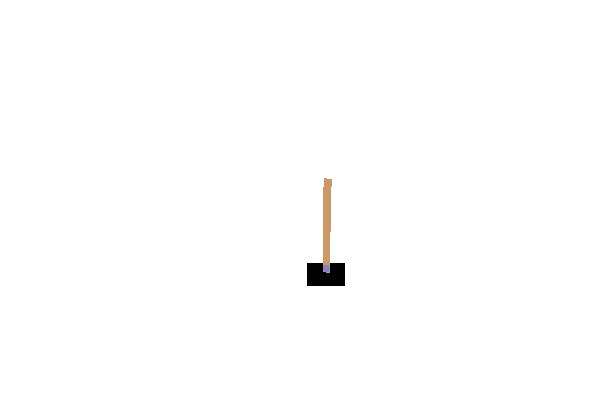
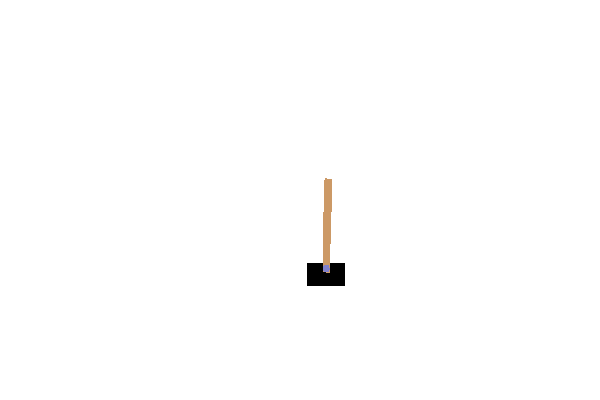
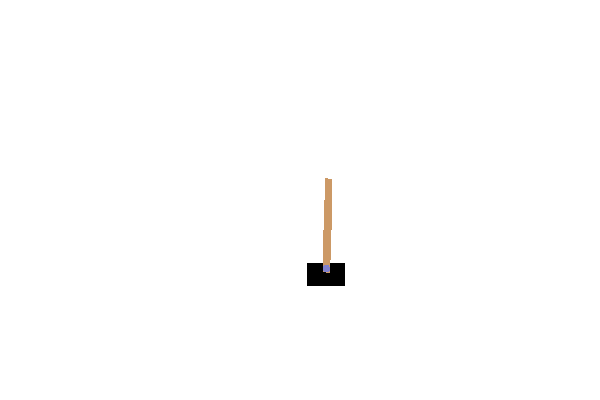
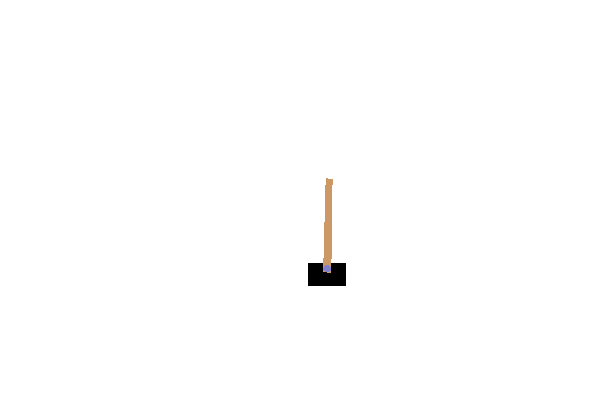
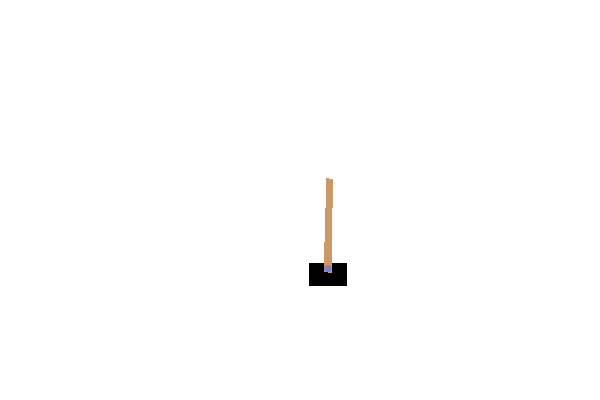
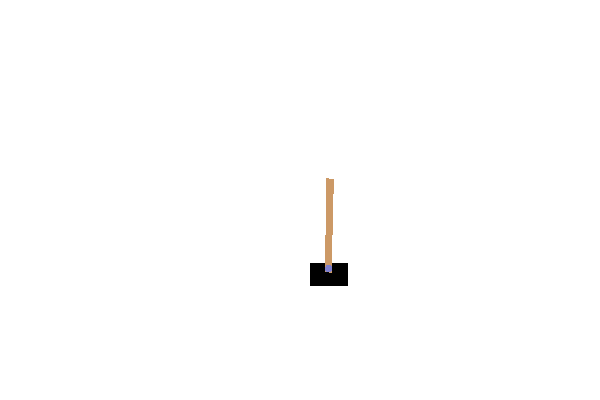
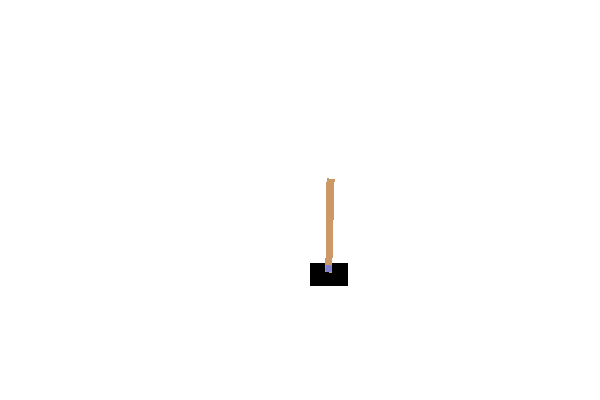
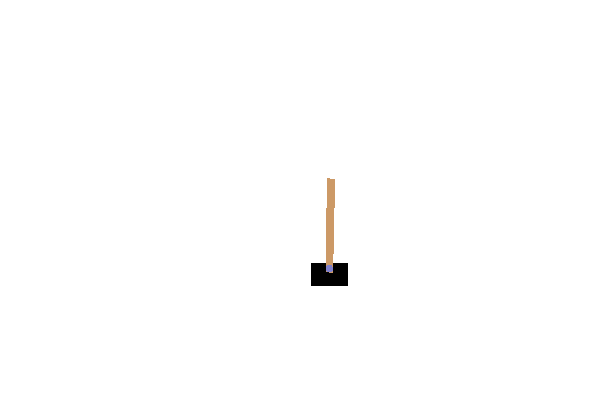
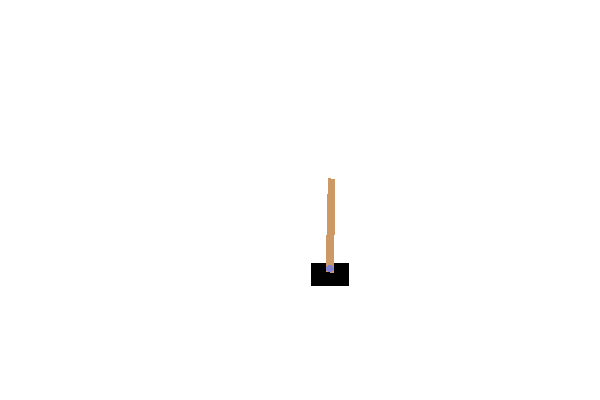
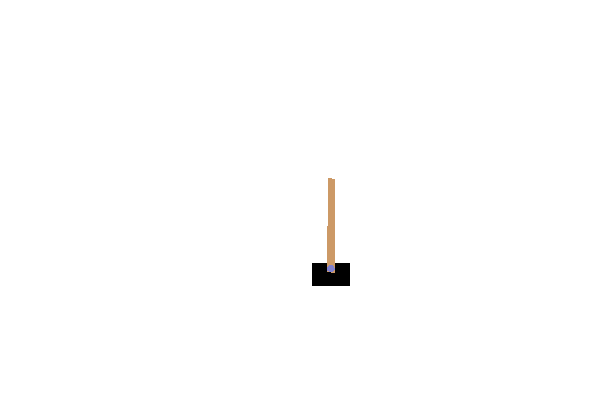
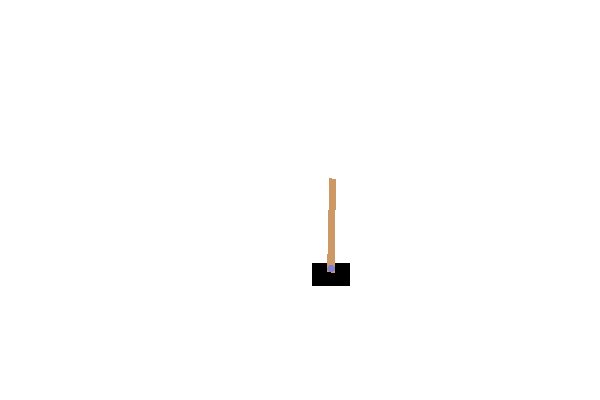
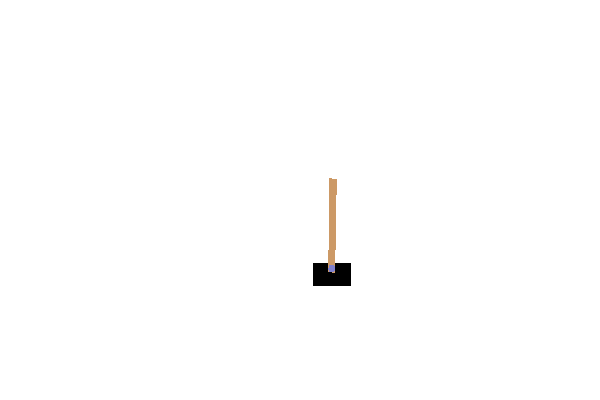
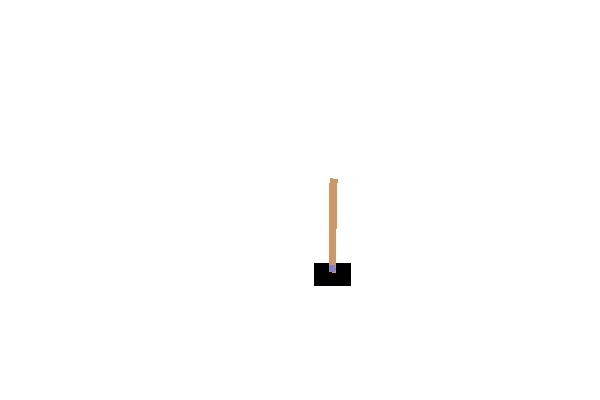
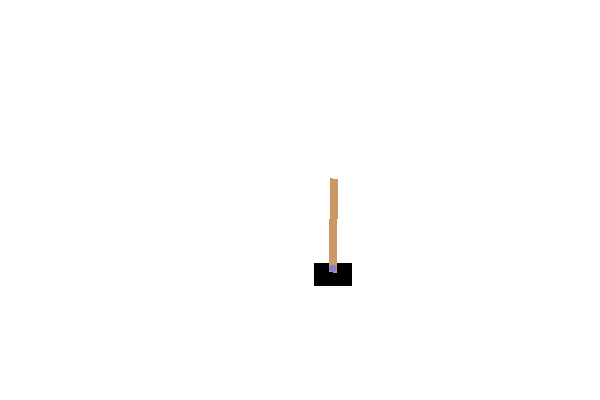
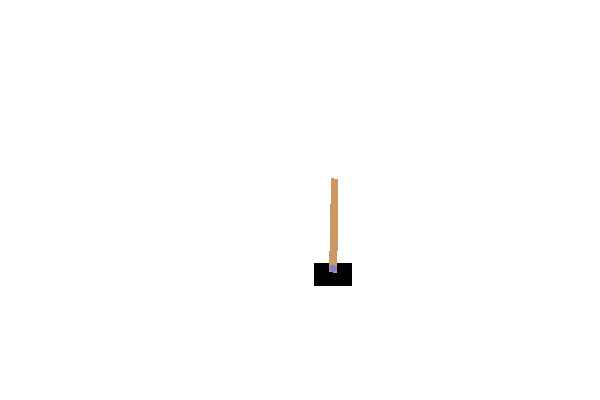
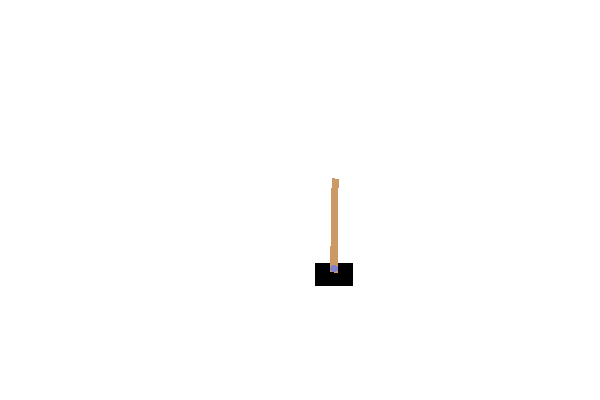
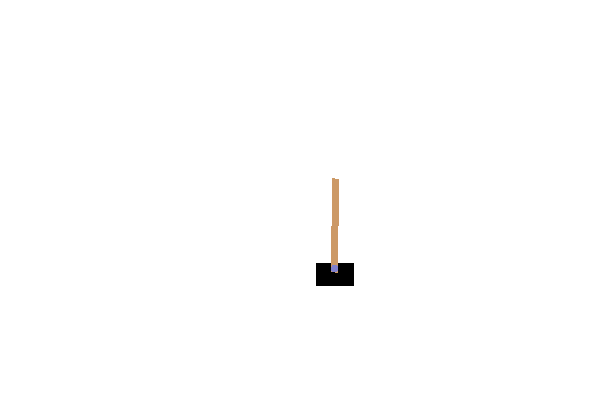
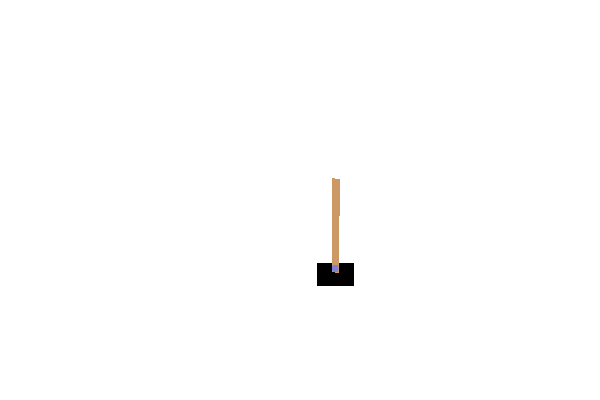
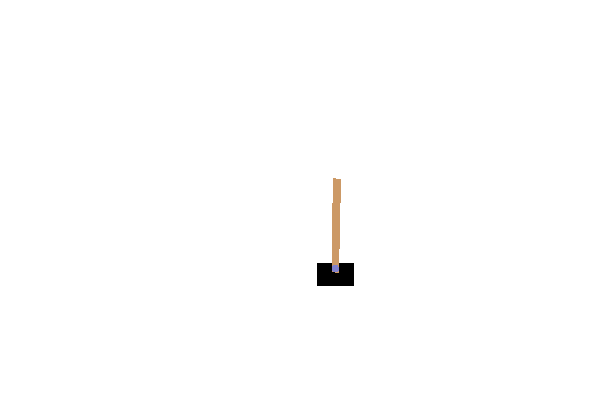
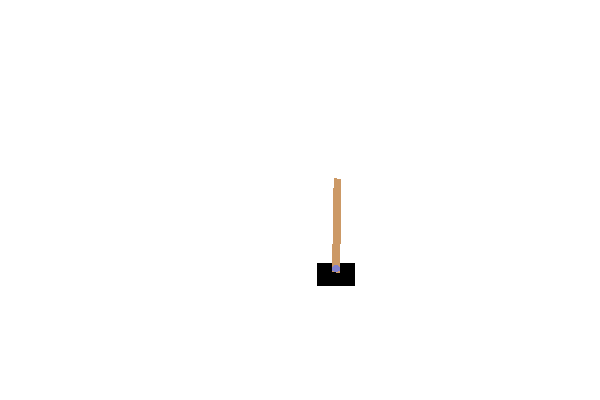
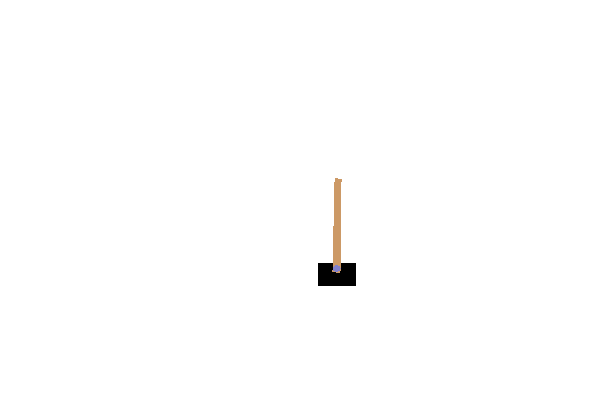
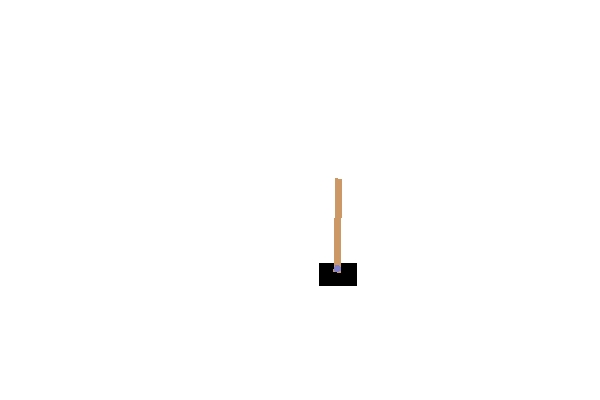
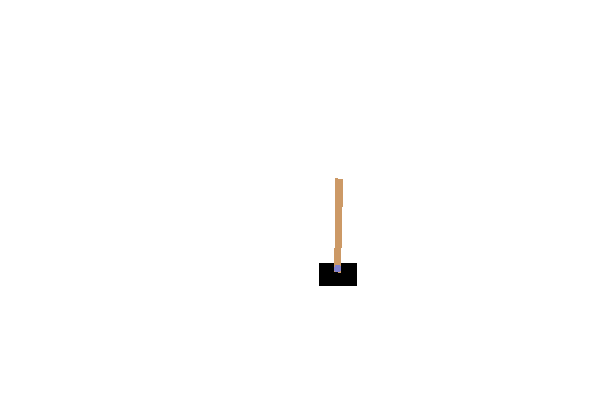
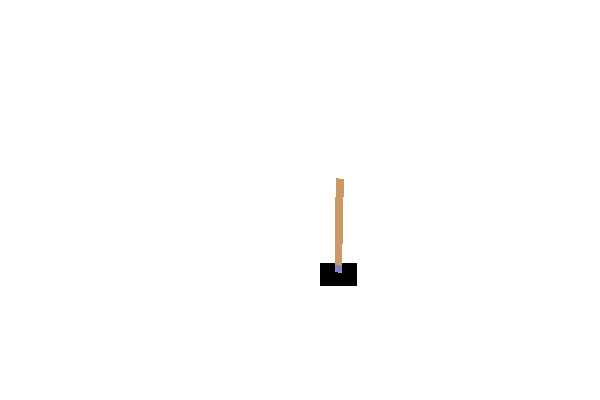
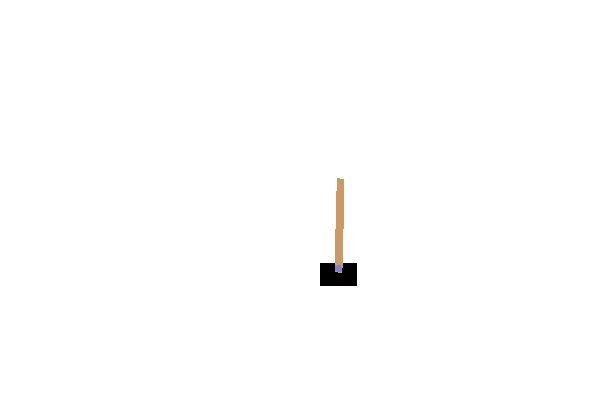
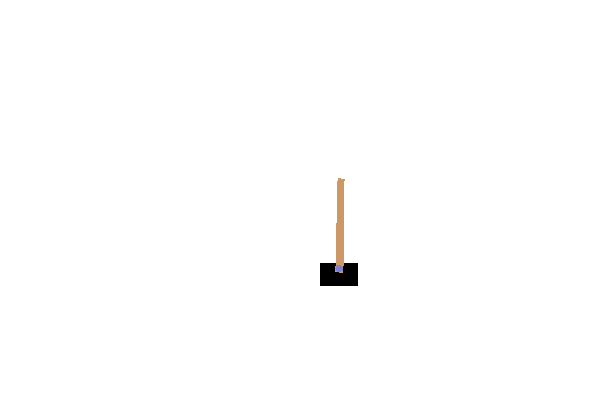
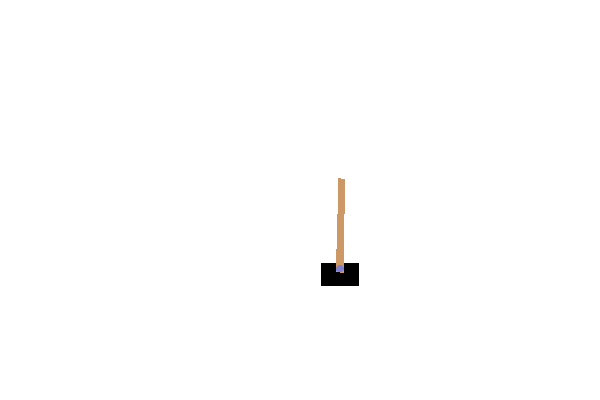
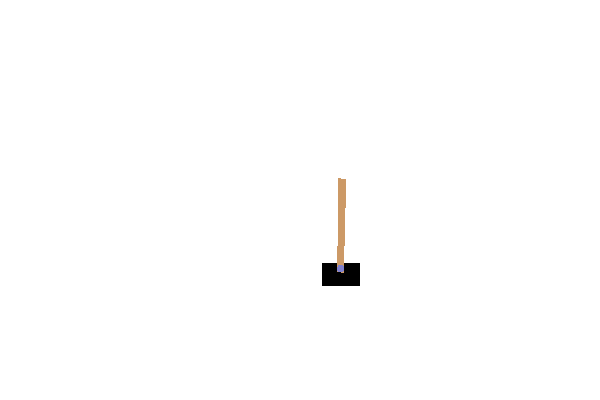
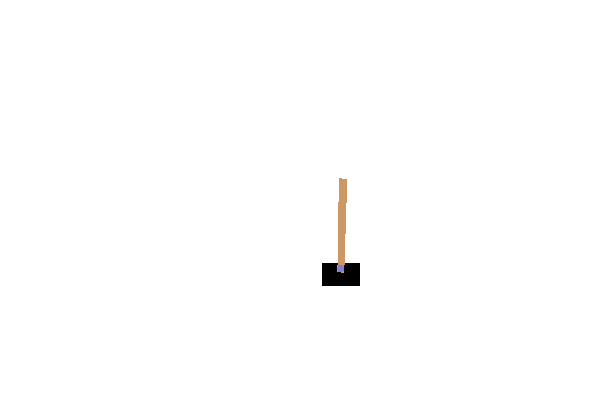
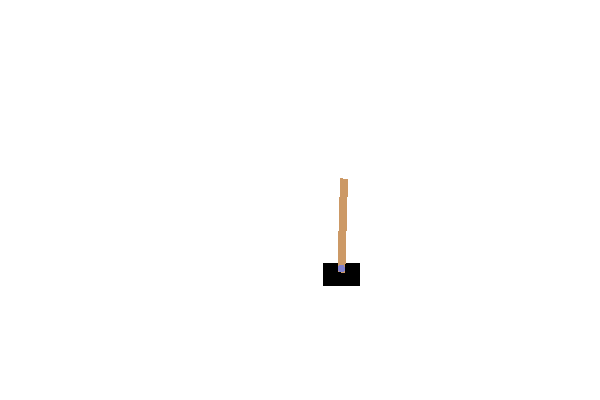
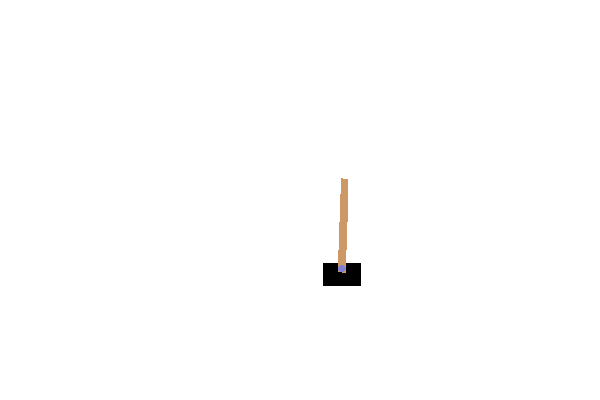
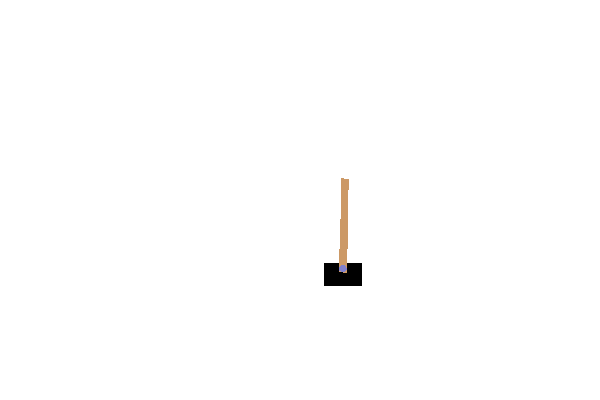
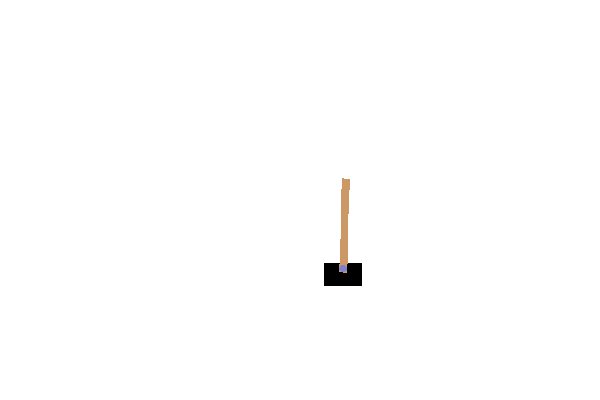
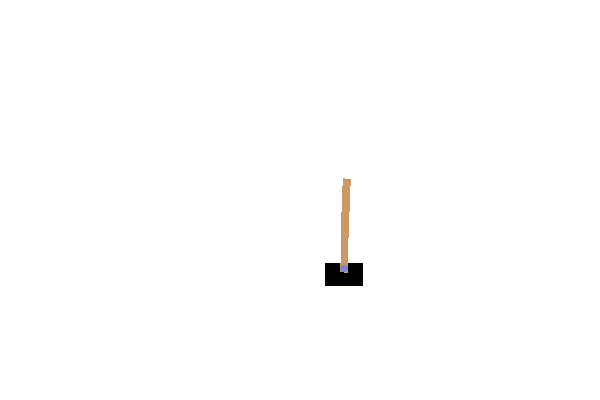
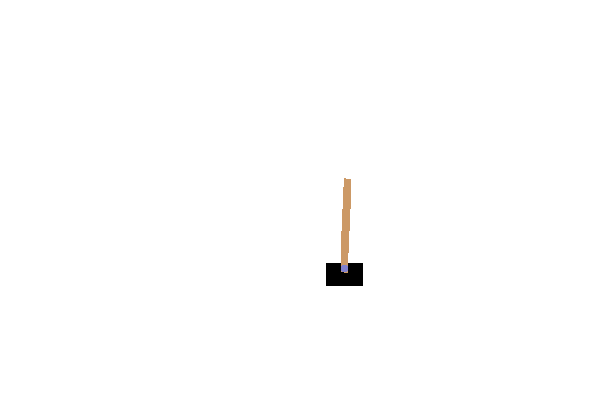
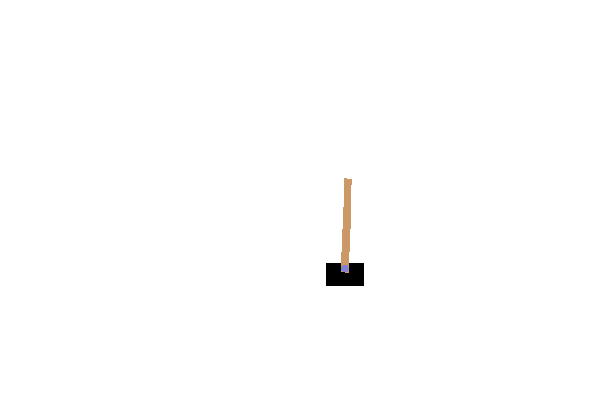
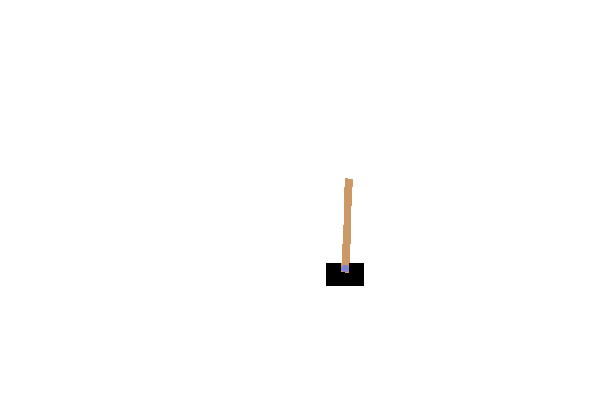
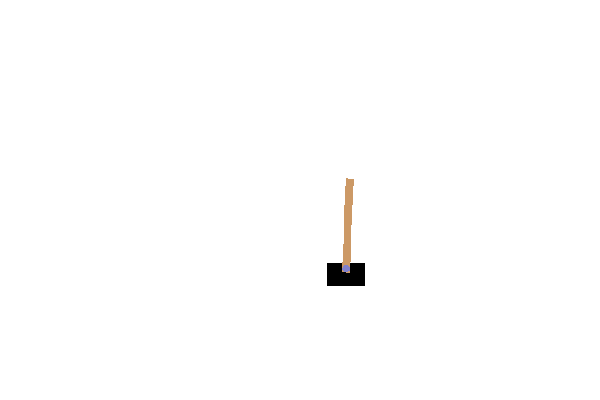
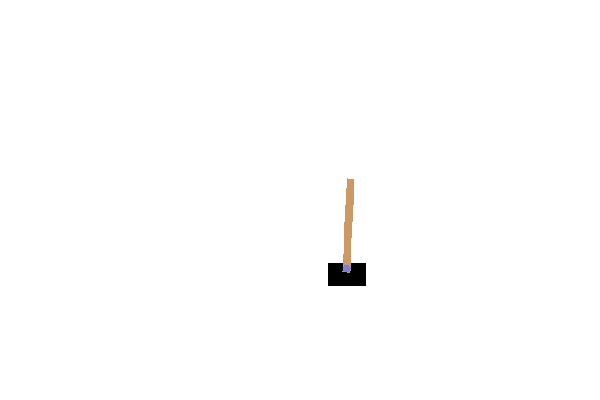
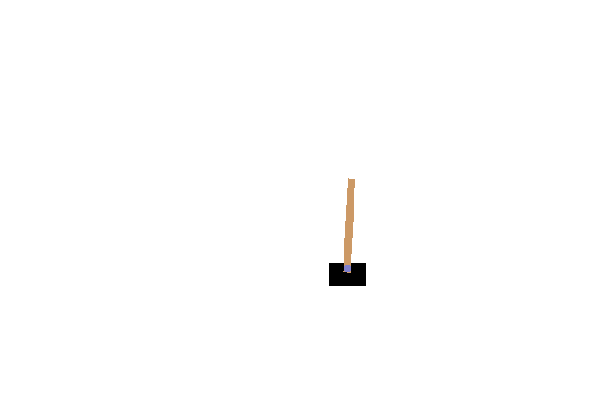
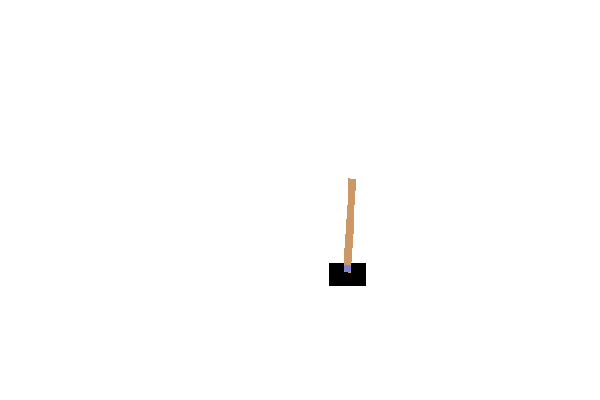
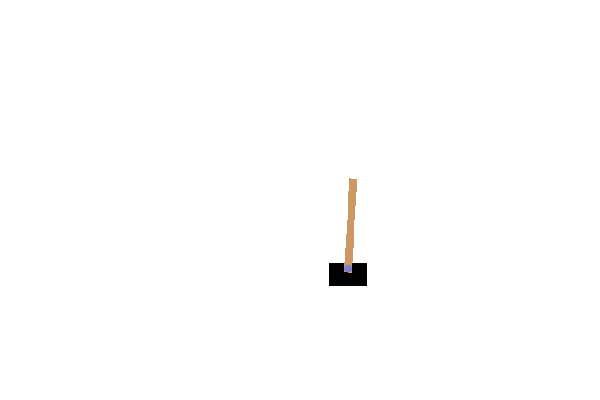
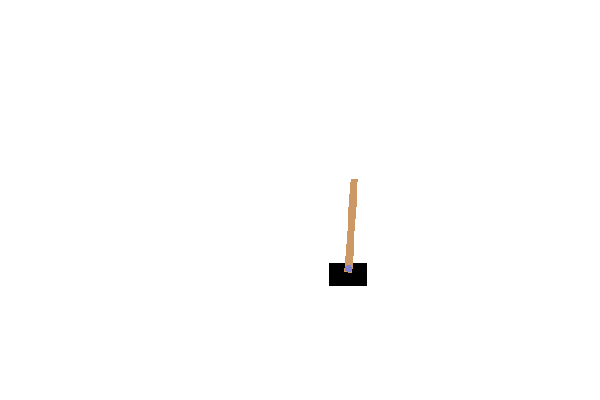
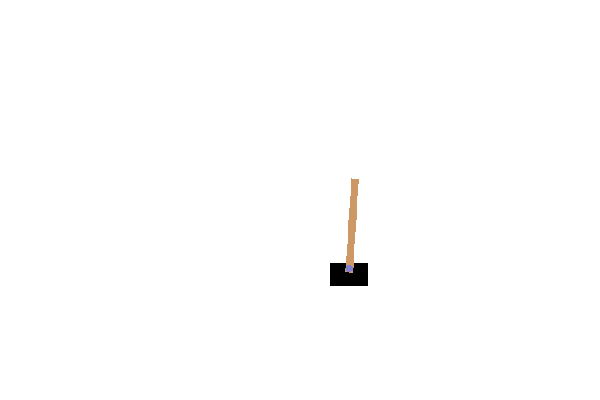
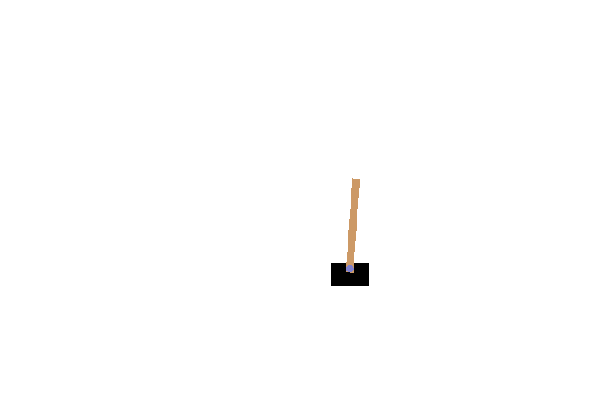
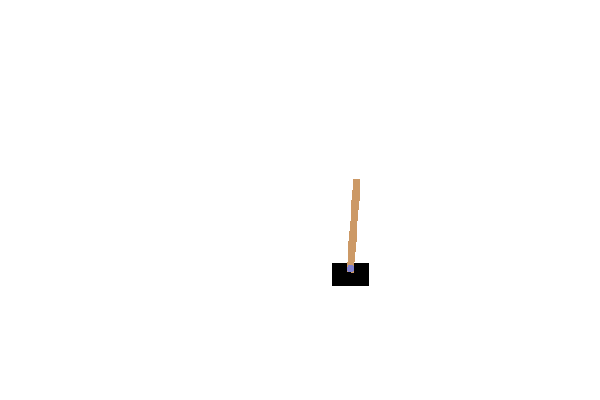
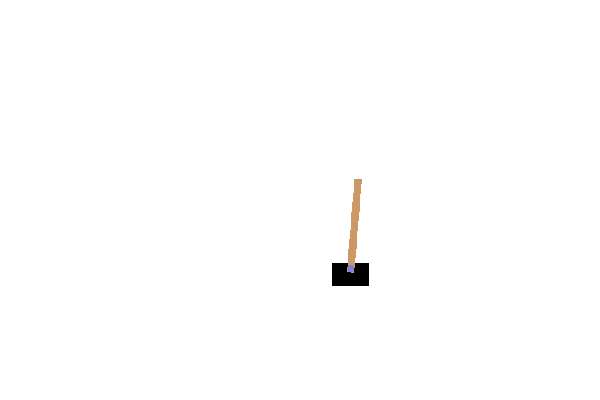
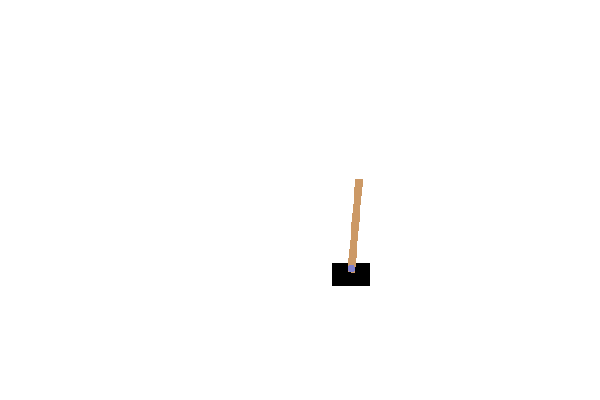
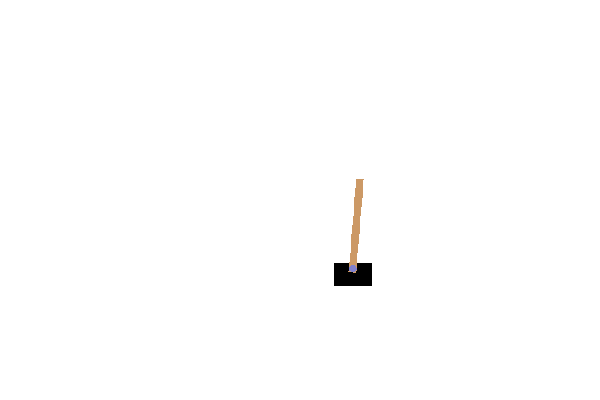
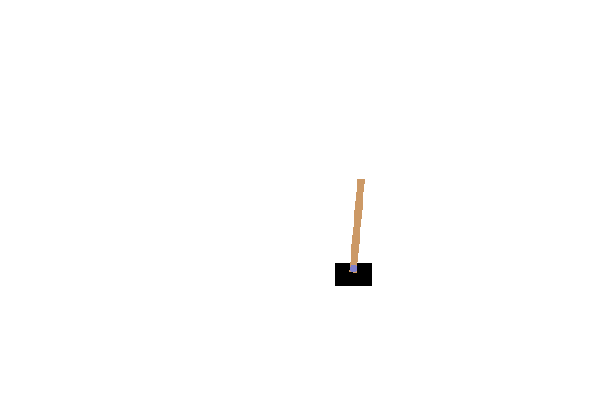
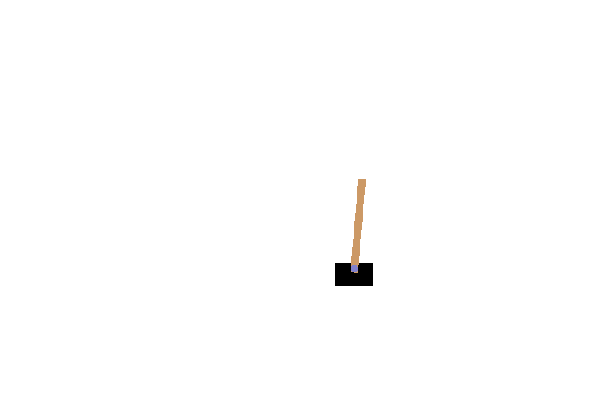
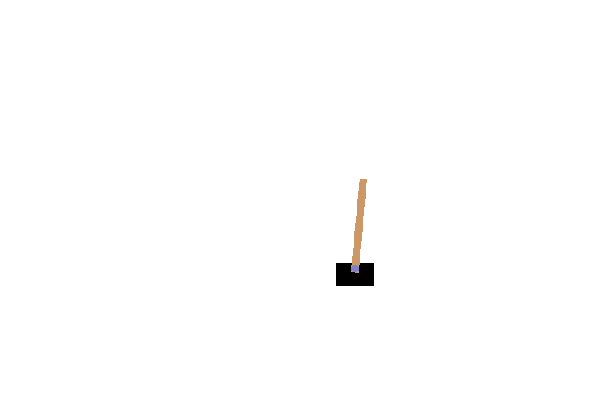
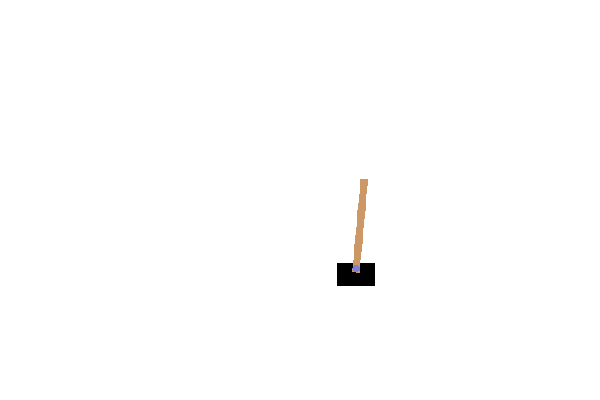
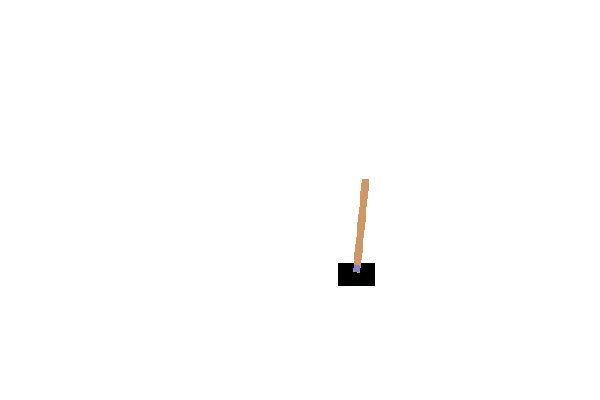
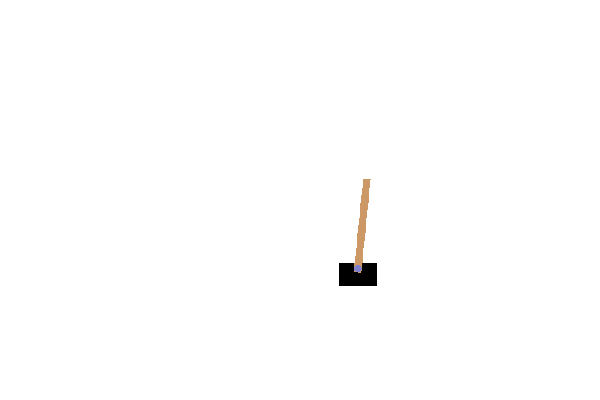
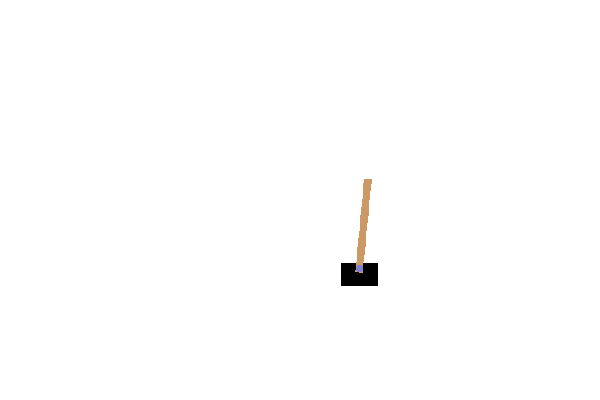
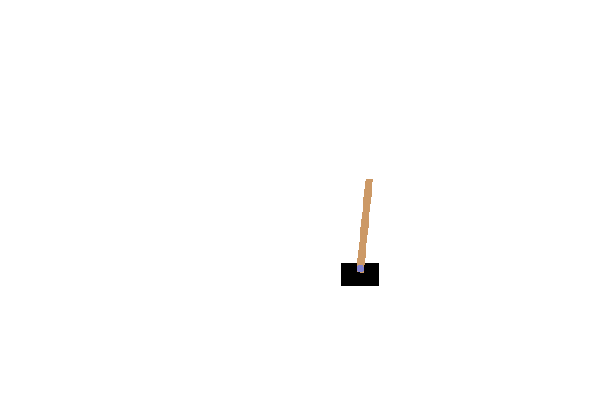
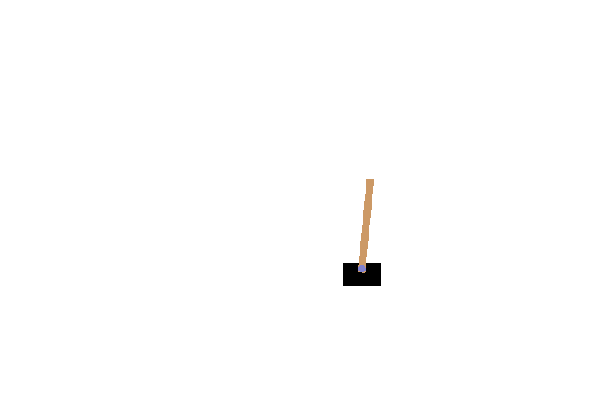
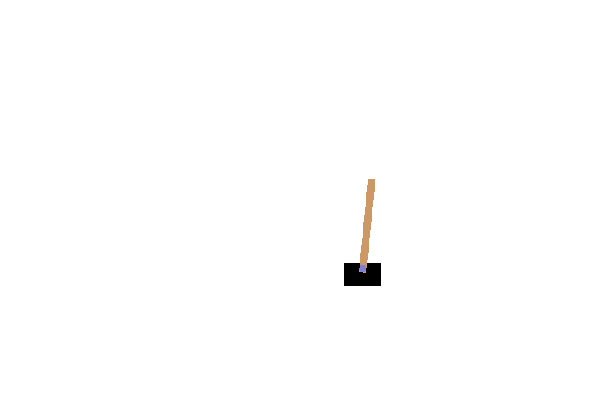
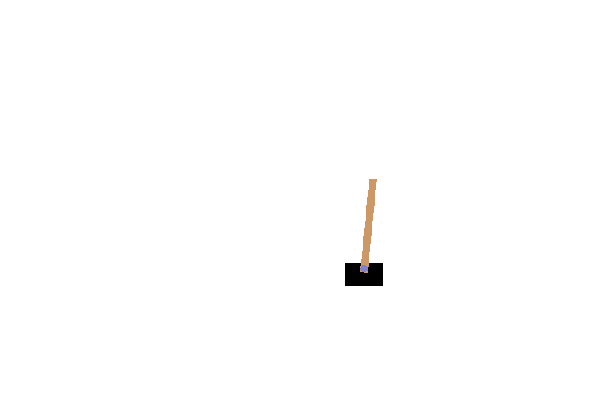
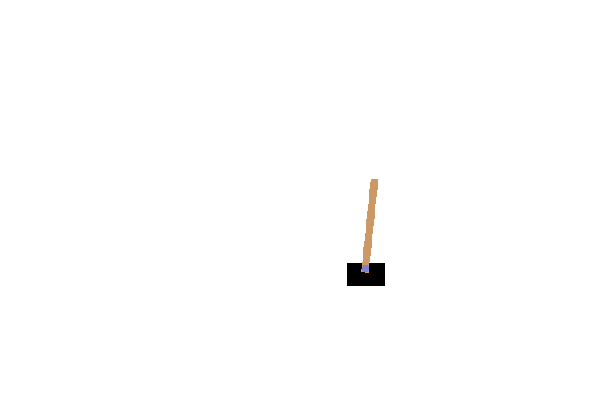
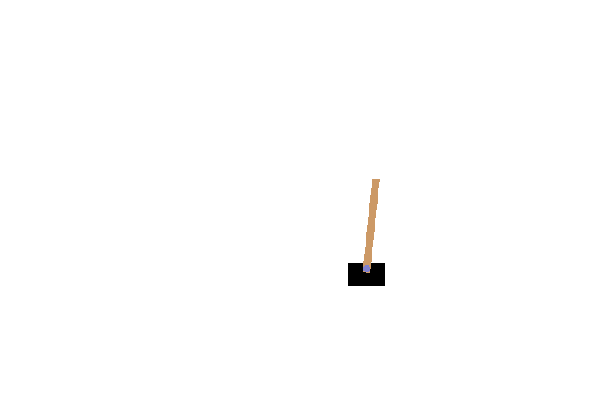
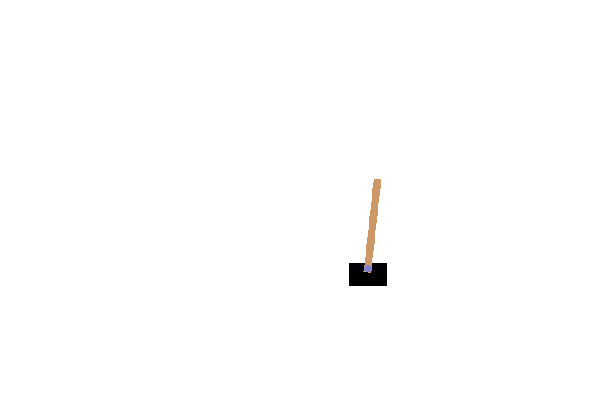
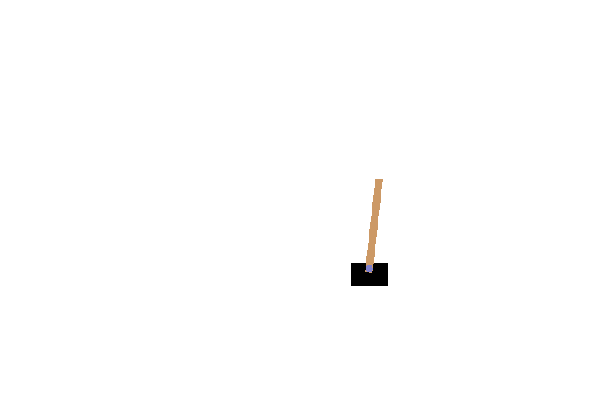
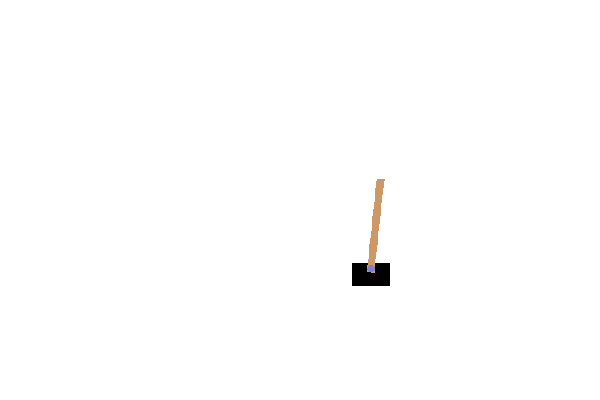
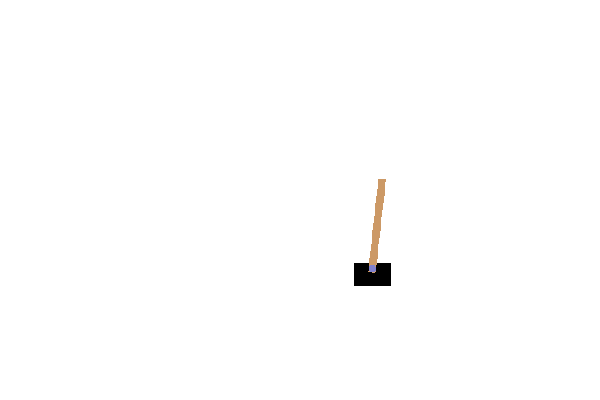
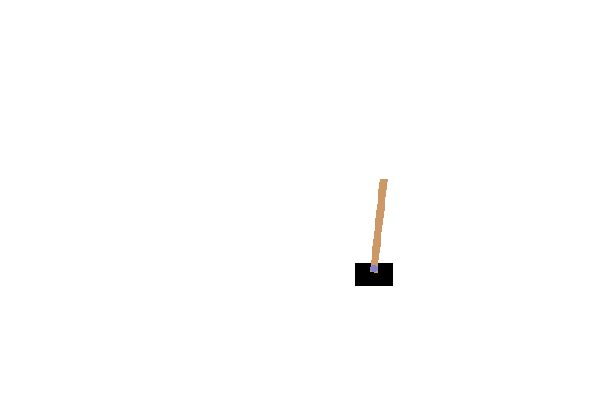
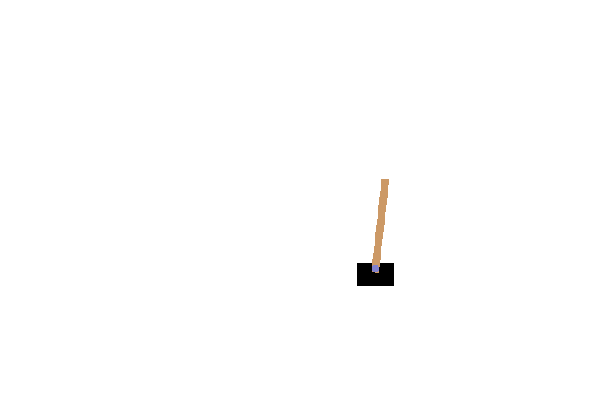
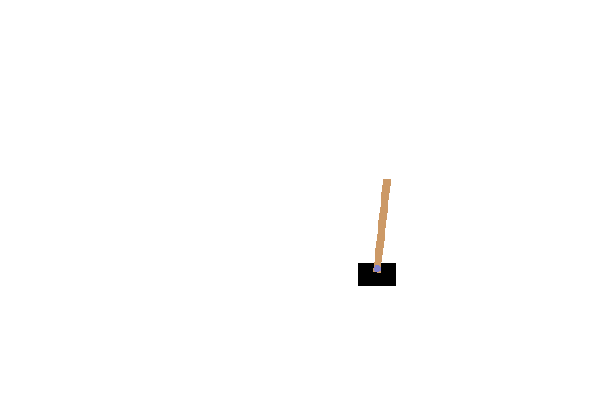
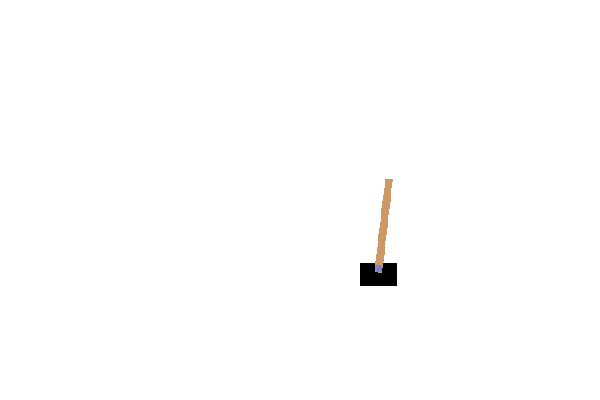
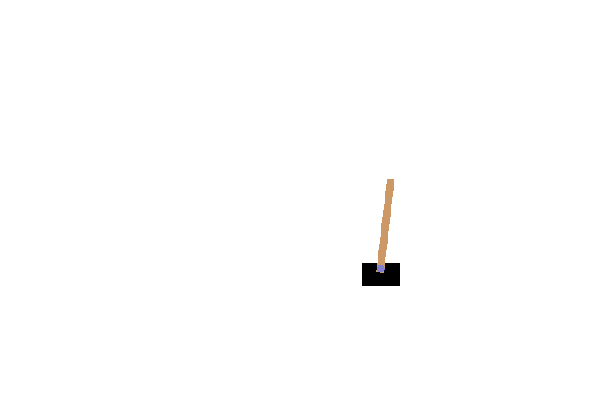
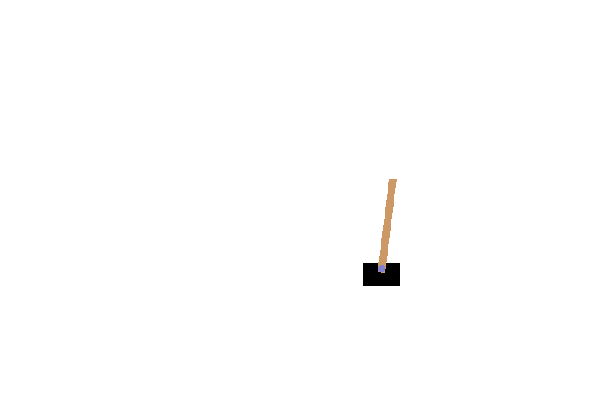
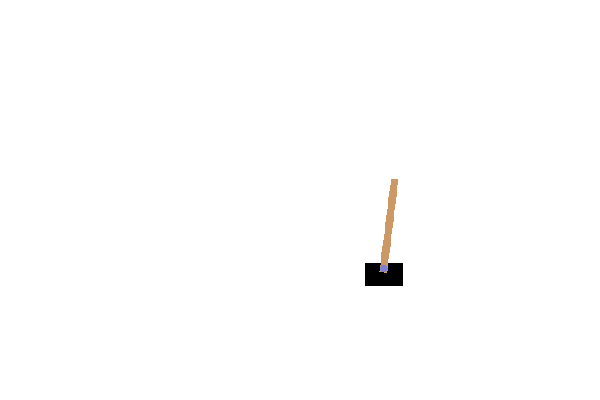
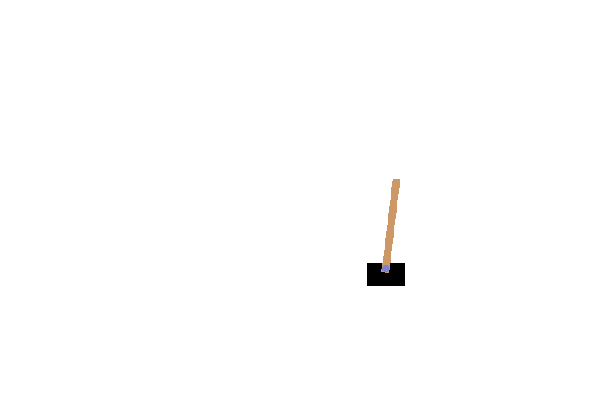
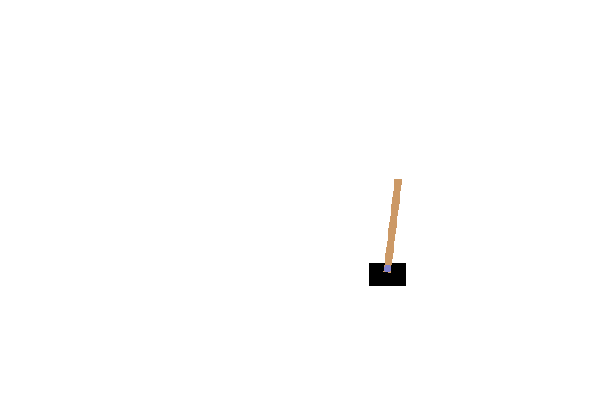
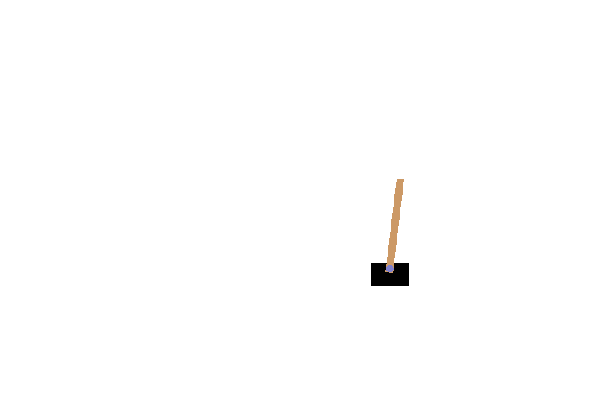
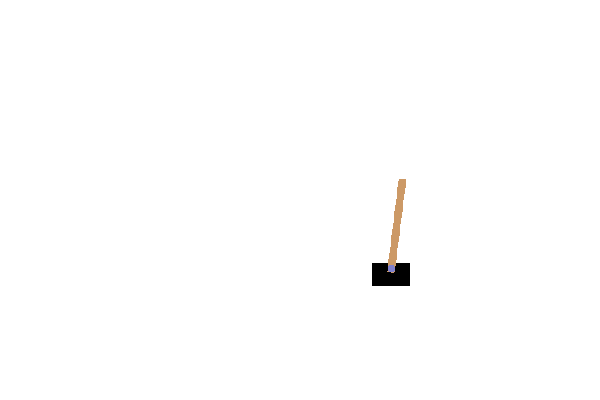
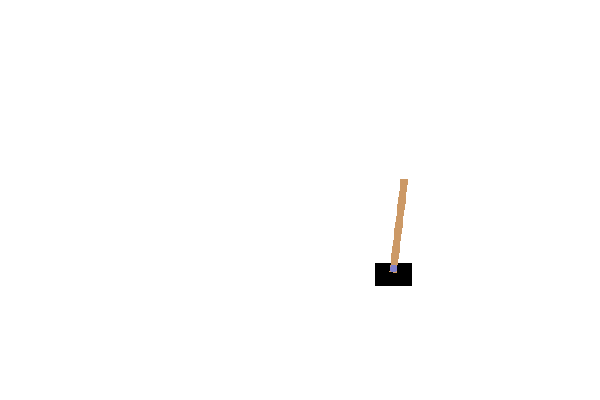
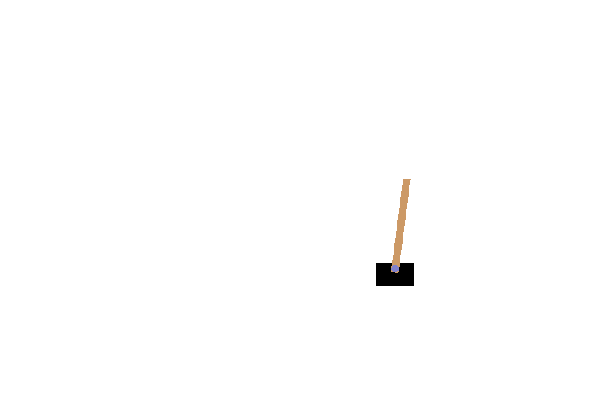
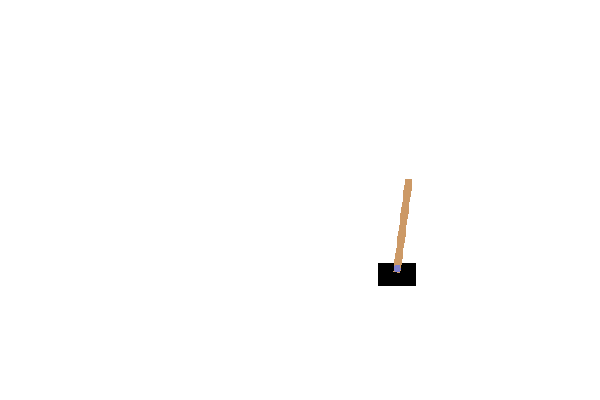
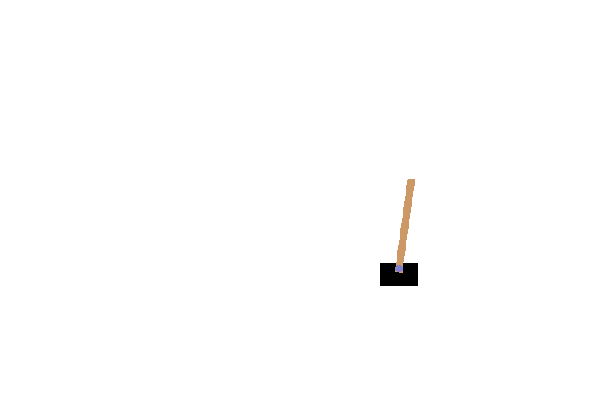
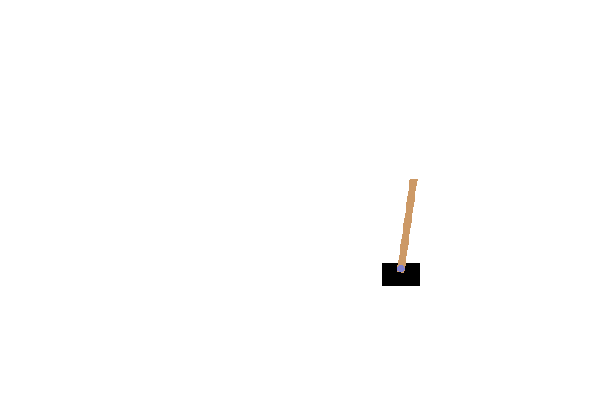
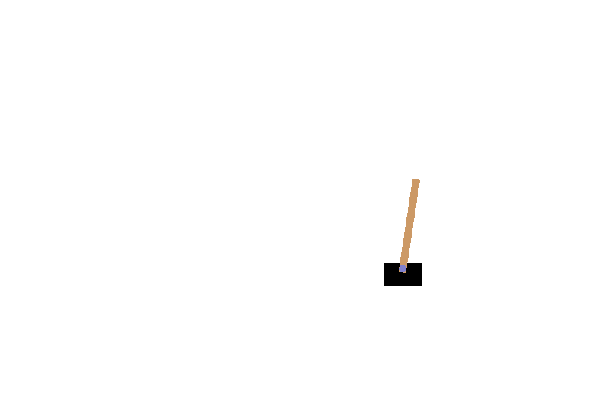
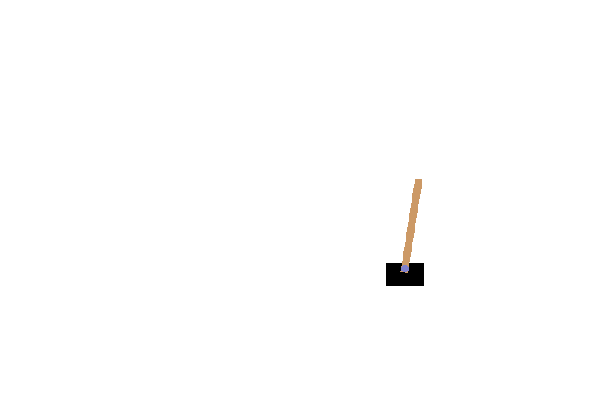
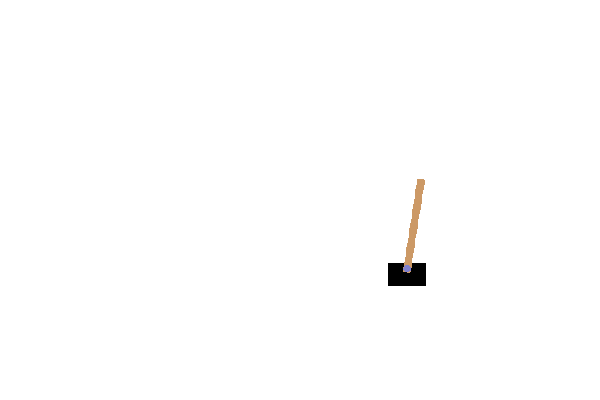
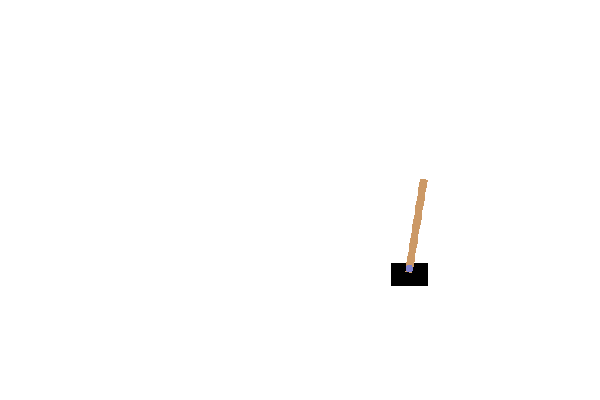
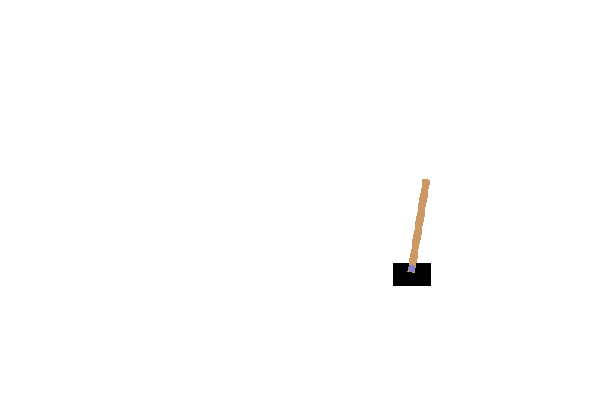
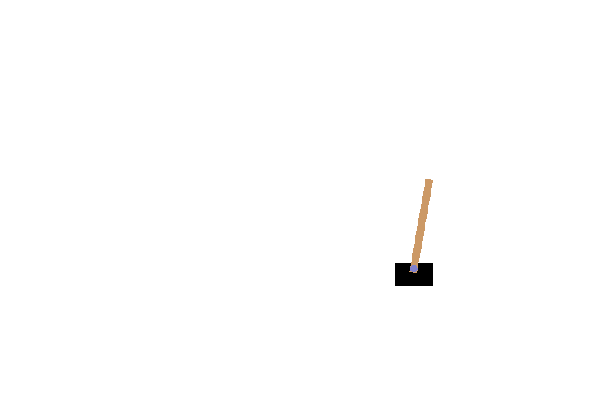
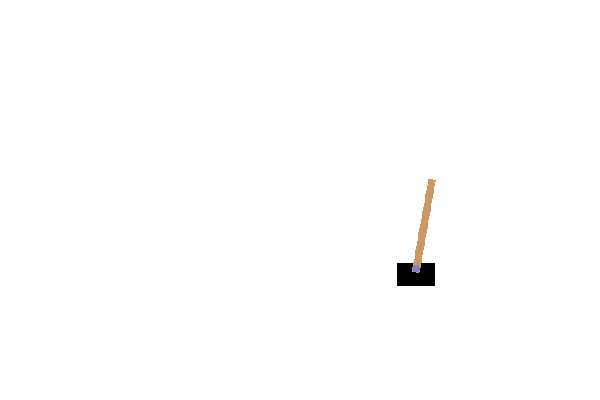
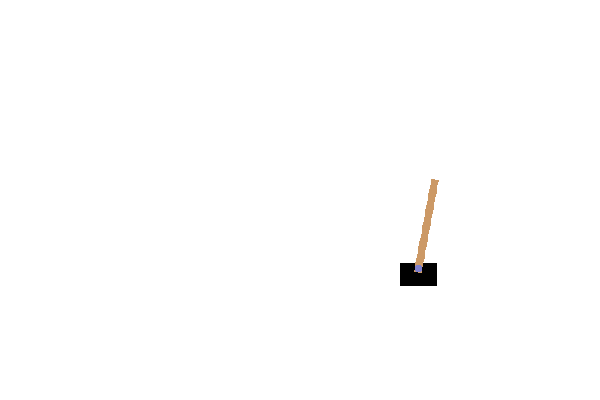
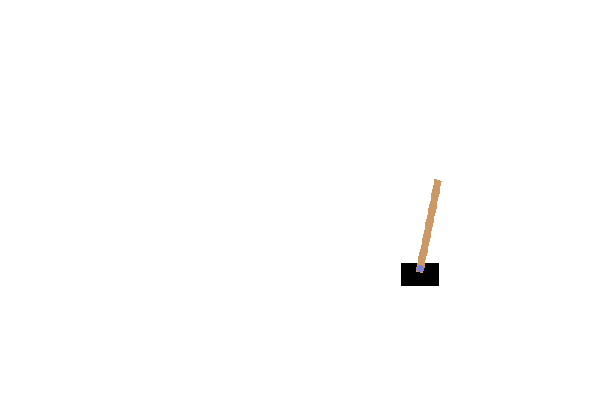

In [9]:
# main クラス
cartpole_env = Environment()
cartpole_env.run()